### General Note. 



In [1249]:
import requests
import bs4 
import pandas as pd 
import docx 

import re 
import urllib.parse 
import io 
import json
import os.path
import os 
import time
import nltk 
import numpy as np
import jieba
import jieba.posseg as pseg

import _pickle as cPickle

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy 
import scipy.cluster.hierarchy
import gensim

import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import operator
from googletrans import Translator
import networkx as nx
import gensim

import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, \
precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from googletrans import Translator

### Section 1.  Scraping the data from qidian website

***Section Overview*** 

In this section, I scraped data from the web novel website qidian (male: https://www.qidian.com/rank/collect?style=2; female: https://www.qidian.com/mm/rank/collect?style=2)

All the operations were run for male and female version of the website separately. 

**Step 1**: Go the the ranking board (male and female separately) to gather links of the popular books --> A list of all book links

**Step 2**: Go to the introduction page of each book, scraped the book demographics (book name, author name, book introduction, total number of bookmark, total number of recommend, total number of clicks, tags assigned to each novel). 

**Step 3**: On the introduction page, there is a button called (trial reading for free). Clicking this button jumps to the first chapter of this book. I scraped 30 chapters of each books by clicking "next page" at the bottom of each chapter.

**Iteration**: Scraping the books sometimes gives me errors. But trying for a second or third time may work. I therefore write an iteration that would collect the books that were unsuccessful for the first time and then tried a second, a third, even a fourth time.

**Results**: The results of this section is two dataframe, one for 500 males novels and one for 500 female novels. The shape of the novels are 

    500*12 : 
    500 books * (1.'author', 2.'click_count', 3.'example_text', 4.'intro', 5.'intro_mentioned_books', 6.'name', 7.'recom_count', 8.'tags', 9.'word_count' (of the book), 10.'num_bookmarked', 11.'book_url', 12.'book_rank').

In [ ]:
##Gathering book links from the ranking board before processing the books
##The ranking board includes 10 pages; each page includes 50 books. 
##500 books in total on the ranking board. 
BookList= []
for p in range(1,11):
    #For the male version of the website
    #rank_url= "https://www.qidian.com/rank/collect?style=2&page={}".format(p)
    
    #For the female version of the website 
    rank_url= "https://www.qidian.com/mm/rank/collect?style=2&page={}".format(p)

    page_request= requests.get(rank_url)
    page_soup= BeautifulSoup(page_request.text, "lxml")

    url_list= page_soup.body.find("div", attrs= {"class": "rank-view-list"})\
               .find_all("a", attrs= {"class": "name"}) #Continuing the previous line!!!
    bookmark_list= page_soup.body.find_all("td", attrs= {"class": "month"})
    for i in range(50): #The page is well structured; 50 books a page
        a_book= [url_list[i]["href"], int(bookmark_list[i].text)]
        BookList.append(a_book)

#Output of this loop is links of the books on the ranking broad.
#Output is list within list
#[[book1's url, number of being bookmarked], [book2's url, number of being bookmarked], etc]
print(len(BookList))
print(BookList[:10])

In [ ]:
##I store the book links in a excel file
"""
BookList_male= pd.DataFrame(BookList)
BookList_male.to_csv("bookList_male.csv")
"""
BookList_female= pd.DataFrame(BookList)
BookList_female.to_csv("bookList_female.csv")

In [ ]:
##These functions are for dealing with individual book links
##and gathering information of each book

def soup_a_book(a_book_url):
    ##Extracting book introduction from a webpage+ 
    ##Using Beautifulsoup to parse a book's web page
    a_book_request= requests.get(a_book_url)
    a_book_soup= BeautifulSoup(a_book_request.text, 'lxml')
    return a_book_soup


def get_intro(a_book_soup):
    #Following the previous function, get the book's introductio and get rid of "\u3000"
    for_intro= a_book_soup.body.find("div", attrs= {"class": "book-intro"})
    intro= re.sub(r"\u3000", " ", for_intro.text.strip()) #(Regular Expression 1)
    return intro

def get_book_demo(a_book_soup):
    ###Book demographics###
    for_info= a_book_soup.body.find("div", attrs= {"class": "book-info"})

    #name, author
    name= for_info.text.split()[0]
    author= for_info.text.split()[1]
    
    linked_text= re.findall(r"\d+.\d+.*总推荐", for_info.text)[0] #(Regular Expression 2)
    #The above re.findall() returns a list, I take its element as string.
    splited_text= linked_text.split("|")
    #print(splited_text)

    #word count
    word_count= splited_text[0] 

    #click count
    click_count= re.findall(r"\d+.\d+.*总点击", splited_text[1])[0] #(Regular Expression 3)  
    
    #recommendation count
    recom_count= splited_text[2] #(Regular Expression 3)  

    #tags
    tags= a_book_soup.body.find_all("a", attrs= {"class": "red"})
    tags= [i.text for i in tags]
    tags_string= "" 
    for t in tags:
        tags_string+= t+ ";"

    return name, author, word_count, click_count, recom_count, tags_string


def get_IntroMentioned_books(intro, name):
    #Input of this function:
    #uses output of TWO of the above functions get_intro() and get_book_demo()
    #Lookinf for other books mentioned in the book introduction
    all_mentioned= re.findall(r"《(.*?)》", intro) #(Regular Expression 4)
    other_books= [i for i in all_mentioned if i!= name]
    other_books_string= ""
    for o in other_books:
        other_books_string+= o+ ";"
    return other_books_string


def get_text(a_book_soup):
    #Input is the soup of the introduction page of the book 
    #Obtain the first 30 chapters as example writing, 30 chapters are stored in one dictionary
    
    #Using the introduction page to get the the "read for free (= first page)"
    def get_content(for_read_url):
        read_url= "https:"+ for_read_url

        ch= requests.get(read_url)
        ch_soup= BeautifulSoup(ch.text, 'lxml')
        #Attention: "html.parser" gives me a TypeError called:
        #TypeError: 'NoneType' object is not subscriptable
        #This problem is no longer there, if I use "lxml" as parser

        chP= ch_soup.body.find("div", attrs= {"class": "read-content"}).find_all("p")
        chP_joined= ""
        for p in chP:
            chP_joined+= str(p)   
        chP_joined= chP_joined.replace("\u3000", "")
  
        ch_content= re.sub(r"(<\/*p>)(\1*)", "", chP_joined) #(Regular Expression 5)
        ch_content= ch_content.strip()
        return ch_content, ch_soup
    
    content_dic= {}
    i= 1 
    while i< 31:
        if i== 1:
            for_read_url= a_book_soup.body.find("a", text= "免费试读")["href"] 
            ch_content, ch_soup = get_content(for_read_url)
            content_dic[i]= ch_content
            i+= 1
        else:
            for_read_url= ch_soup.body.find("a", text= "下一章")["href"]
 
            ch_content, ch_soup = get_content(for_read_url)
            content_dic[i]= ch_content
            i+= 1
    
    return content_dic

def deal_with_a_book(a_book_url):
    a_book_soup= soup_a_book(a_book_url)
    intro= get_intro(a_book_soup)
    name, author, word_count, click_count, recom_count, tags_string= get_book_demo(a_book_soup)
    other_books_string= get_IntroMentioned_books(intro, name)
    content_dic= get_text(a_book_soup)
    
    a_book_dic= {'name' : name, "author": author, "intro": intro, 
                 "word_count": word_count, "click_count": click_count, 
                 "recom_count": recom_count,
                 "tags": tags_string, "intro_mentioned_books": other_books_string, 
                 "example_text": content_dic}
    helper= [a_book_dic]
    bookDF= pd.DataFrame(data= helper)
    return bookDF, a_book_soup

In [ ]:
##Processing the 500 books and output a data frame

t0 = time.time()

bookDF_female_200_500= pd.DataFrame({})
book_error_recording= "book_error_recording.txt"


for book in BookList[200:500]:
    try:
        book_url= "https:"+ book[0]
        a_bookDF, a_book_soup= deal_with_a_book(book_url)
        #The "number of being bookmarked" information is not available on the
        #book introduction page. This information is available on the book ranking page. 
        #I add a column for each book about its number of being bookmarked:
        a_bookDF["num_bookmarked"]= book[1]
        a_bookDF["book_url"]= book_url
        a_bookDF["book_rank"]= BookList.index(book)

        if a_bookDF.shape[1]== 12:
            bookDF_female_200_500= bookDF_female_200_500.append(a_bookDF)
            bookDF_female_200_500.to_pickle("bookDF_female_200_500.pickle")
            print(bookDF_female_200_500.shape)
        else:
            print("Does not generate 12-column book:", book_url)
    except:
        print("Error in book:", book_url)
        fw= open("book_error_recording.txt", "a")
        fw.write("\n Error in book:"+ book_url)
        fw.close()


t1 = time.time()
total = t1-t0
print(total)

In [ ]:
##I scraped the 500 books in two times. 

##For male
bookDF_male_0_200= pd.read_pickle("bookDF_male_0_200.pickle")
bookDF_male_200_500= pd.read_pickle("bookDF_male_200_500.pickle")
bookDF_male= bookDF_male_0_200.append(bookDF_male_200_500)
bookDF_male.to_pickle("bookDF_male.pickle")
bookDF_male.shape

In [ ]:
##For female
bookDF_female_0_200= pd.read_pickle("bookDF_female_0_200.pickle")
bookDF_female_200_500= pd.read_pickle("bookDF_female_200_500.pickle")
bookDF_female= bookDF_female_0_200.append(bookDF_female_200_500)
bookDF_female.to_pickle("bookDF_female.pickle")
bookDF_female.shape

<span style="color:darkred"> **The following of this section is to solve technical issues and not substantially important**

**Iteration for books that are unsuccessfully scraped for the first time** The above run the code for one time and loop through 500 books on the ranking board for male and female version of the website, respective. However, some webpages were not successfully processed and generate errors. In the following, I re-process the webpages that were not successfully processed for the first time.
For the male version, the recursive codes successfully scraped the data of all books.
For the female version, the problem is not just random problem of the website, but is actually due to my codes. I have to modify my code to deal with the problem in the "deal_with_a_book()" function. I do not make modification above, so avoid messing with the code that works on 995 cases. I copy and past the function above and make the modification just for the 5 books that cannot be procesed (named "Extra Section").

In [ ]:
#Re-processing the error books 
#(The errors occured for unknown reason. Not because the pages are problematic
#If I run it for another time, there is no problem at all.

#For the male data frame
##I store the booklist as a data frame. Read it back to a list. 
bookpd_male= pd.read_csv("bookList_male.csv")
booklist_male= []
for i in range(bookpd_male.shape[0]):
    booklist_male+= [list(bookpd_male.iloc[i][1:3])]
##load the scraped dataframe
bookDF_male= pd.read_pickle("bookDF_male.pickle")
##Find the ones that were not successfully included in the scraped data
error_male= []
for u in booklist_male:
    if "https:"+ u[0] not in list(bookDF_male["book_url"]):
        error_male+= [u]

##Copy and paste the codes I used above + Modeification!
##I write the code recursively. It will only stop until all the errored books are processed. 
while True:
    if len(error_male)== 0:
        break
    else:
        for book in error_male:
            try:
                book_url= "https:"+ book[0]
                a_bookDF, a_book_soup= deal_with_a_book(book_url)

                a_bookDF["num_bookmarked"]= book[1]
                a_bookDF["book_url"]= book_url
                a_bookDF["book_rank"]= booklist_male.index(book)

                if a_bookDF.shape[1]== 12:
                    bookDF_male= bookDF_male.append(a_bookDF)
                    bookDF_male.to_pickle("bookDF_male.pickle")
                    error_male.remove(book)
                    print(bookDF_male.shape)
                else:
                    print("Does not generate 12-column book:", book_url)
            except:
                print("Error in book:", book_url)
            

In [ ]:
#For the female data frame (Copy and Paste from the previous male code)
##I store the booklist as a data frame. Read it back to a list. 
bookpd_female= pd.read_csv("bookList_female.csv")
booklist_female= []
for i in range(bookpd_female.shape[0]):
    booklist_female+= [list(bookpd_female.iloc[i][1:3])]
##load the scraped dataframe
bookDF_female= pd.read_pickle("bookDF_female.pickle")
##Find the ones that were not successfully included in the scraped data
error_female= []
for u in booklist_female:
    if "https:"+ u[0] not in list(bookDF_female["book_url"]):
        error_female+= [u]
print(len(error_female))

##I write the code recursively. It will only stop until all the errored books are processed. 
##There are five web pages that cannot be processed. So I had to force restart kenel to
##break out of the loop
while True:
    if len(error_female)== 0:
        break
    else:
        for book in error_female:
            try:
                book_url= "https:"+ book[0]
                a_bookDF, a_book_soup= deal_with_a_book(book_url)

                a_bookDF["num_bookmarked"]= book[1]
                a_bookDF["book_url"]= book_url
                a_bookDF["book_rank"]= booklist_female.index(book)

                if a_bookDF.shape[1]== 12:
                    bookDF_female= bookDF_female.append(a_bookDF)
                    bookDF_female.to_pickle("bookDF_female.pickle")
                    error_female.remove(book)
                    print(bookDF_female.shape)
                else:
                    print("Does not generate 12-column book:", book_url)
            except:
                print("Error in book:", book_url)



In [ ]:
"""
Error in book: https://book.qidian.com/info/2487306
Error in book: https://book.qidian.com/info/1533678
Error in book: https://book.qidian.com/info/1692031
Error in book: https://book.qidian.com/info/2613980
Error in book: https://book.qidian.com/info/3374695
"""
#The problem is in get_book_demo() which further problematizes deal_with_a_book()

def get_book_demo_modi(a_book_soup):
    ###Book demographics###
    for_info= a_book_soup.body.find("div", attrs= {"class": "book-info"})
    #print(for_info.text)
    #print(type(for_info.text))

    #name, author
    name= for_info.text.split()[0]
    author= for_info.text.split()[1]
    
    linked_text= re.findall(r"\d+.*总推荐", for_info.text)[0] #(Regular Expression 2)
    #The above re.findall() returns a list, I take its element as string.
    splited_text= linked_text.split("|")
    #print(splited_text)

    #word count
    word_count= splited_text[0] 

    #click count
    click_count= re.findall(r"\d+.\d+.*总点击", splited_text[1])[0] #(Regular Expression 3)  
    
    #recommendation count
    recom_count= splited_text[2] #(Regular Expression 3)  

    #tags
    tags= a_book_soup.body.find_all("a", attrs= {"class": "red"})
    tags= [i.text for i in tags]
    tags_string= "" 
    for t in tags:
        tags_string+= t+ ";"

    return name, author, word_count, click_count, recom_count, tags_string



def deal_with_a_book_modi(a_book_url):
    a_book_soup= soup_a_book(a_book_url)
    intro= get_intro(a_book_soup)
    name, author, word_count, click_count, recom_count, tags_string= get_book_demo_modi(a_book_soup)
    other_books_string= get_IntroMentioned_books(intro, name)
    content_dic= get_text(a_book_soup)
    
    a_book_dic= {'name' : name, "author": author, "intro": intro, 
                 "word_count": word_count, "click_count": click_count, 
                 "recom_count": recom_count,
                 "tags": tags_string, "intro_mentioned_books": other_books_string, 
                 "example_text": content_dic}
    helper= [a_book_dic]
    bookDF= pd.DataFrame(data= helper)
    return bookDF, a_book_soup

In [ ]:
#Process the last 5 books
bookpd_female= pd.read_csv("bookList_female.csv")
booklist_female= []
for i in range(bookpd_female.shape[0]):
    booklist_female+= [list(bookpd_female.iloc[i][1:3])]
##load the scraped dataframe
bookDF_female= pd.read_pickle("bookDF_female.pickle")
##Find the ones that were not successfully included in the scraped data
error_female= []
for u in booklist_female:
    if "https:"+ u[0] not in list(bookDF_female["book_url"]):
        error_female+= [u]
print(len(error_female))

while True:
    if len(error_female)== 0:
        break
    for book in error_female:
        try:
            book_url= "https:"+ book[0]
            a_bookDF, a_book_soup= deal_with_a_book_modi(book_url)

            a_bookDF["num_bookmarked"]= book[1]
            a_bookDF["book_url"]= book_url
            a_bookDF["book_rank"]= booklist_female.index(book)

            if a_bookDF.shape[1]== 12:
                bookDF_female= bookDF_female.append(a_bookDF)
                bookDF_female.to_pickle("bookDF_female.pickle")
                error_female.remove(book)
                print(bookDF_female.shape)
            else:
                print("Does not generate 12-column book:", book_url)
        except:
            print("Error in book:", book_url)

In [4]:
bookDF_female= pd.read_pickle("bookDF_female.pickle")
bookDF_female.shape

(500, 12)

### Section 2. Data Preprocessing (tokenizing, POS tagging, stopwords removing)

***Section Overview***

All the codes were run on male and female dataframe separately. I should have combine the male and female dataframes and just add a column called "gender" to distinguish. But somehow, it did not occur to me at the time. Since running the codes separately like this does not influence the results of pre-processing (besides being inefficient) and the codes above takes rather long. I will leave the codes like this. 

Here are the things that I completed with the codes below. These tasks do not necessarily get completed in different code blocks (e.g., task 1 and task 2 are done in one function).

**Task 1**: In the previous section, the 30 chapters of one book is stored within a dictionary in one cell. Here, I expand this 30-item dictionary and make each chapter correspond to one cell.  

**Task 2**: I use `jieba` package to tokenize book introduction and the 30 chapters of each book, I stored the results in separate columns (12+ 31 columns).

**Task 3**: Parallel to task 2, I use POS tagging function of `jieba` to process the book introduction text and the 30-chapter text so that the novel text is tokenized and tagged. (12+ 31+ 31 columns)

**Task 4**: I construct the list of stopwords from three sources:

    1) I download a list from the internet, which consisits of 738 words. 
    2) POS tags tag all the things that `jieba` cannot recognize as "x". I look up all the tokens of the book introduction that were tagged as "x", and I consider them as stopwords. This step supplements the stopword list I found on the internet especially because the Chinese punctuation is coded differently from English punctuation. For example, in Chinese, comma is "，" but in English it is ",". 
    3) I manually included a few words that occur very often, but are not related to the content of the novel, including '完本'full book, '书号'book number, '群号'group number, '新书'new book, '书友'bookmate, '小说'novel, '作品'production, '读者群'reader group, '读者'reader, '大家'we, '时候'when, '书'book.

**Task 5**: I remove stopwords for tokenized book introduction, for tokenized tagged book introduction, for the 30-column of tokenized chapters, and for the 30-column of tagged chapter, which gives me 62 more columns. This sums up to 12+ 31+ 31+ 62= 136 columns. I store the 500*136 male matrix and 500*136 female matrix separately in pickle files. 

After this section, the dataset is ready for further analysis.

#### Section 2 ~ Male-part

In [10]:
bookDF_male= pd.read_pickle("bookDF_male.pickle")
bookDF_female= pd.read_pickle("bookDF_female.pickle")

In [11]:
def tokenize_ch(thirty_ch):
    #Take the 30-chapter dictionary as input
    #Tokenize the 30 chapters separately and output a list of 30 tokenized word lists (list of list)
    thirty_ch_list= []
    for ch in thirty_ch.keys():
        ch_list= jieba.lcut(thirty_ch[ch], cut_all= False)
        thirty_ch_list+= [ch_list]
    return thirty_ch_list

In [ ]:
##Male
##Tokenize the book chapters. For each chapter (of each book), present under the column "ch?_token"
row_DF_500= pd.DataFrame()
for i in range(bookDF_male.shape[0]):
    #Using the tokenize_ch() function defined above
    book_ch_list= tokenize_ch(bookDF_male["example_text"].iloc[i])
    row_DF= pd.DataFrame()
    for i in range(30):
        row_DF["ch"+str(i+1)+"_token"]= [book_ch_list[i]]
    row_DF_500= pd.concat([row_DF_500, row_DF], axis= 0)
print(row_DF_500.shape)


#Creating a new dataframe
#So as not save any thing to over-write the original data
bookDF_male_tokenized= pd.concat([bookDF_male, row_DF_500], axis= 1)
print(bookDF_male_tokenized.shape)

##Tokenize the book introduction and add a column called "intro_token"
bookDF_male_tokenized["intro_token"]= bookDF_male["intro"].apply(lambda x: jieba.lcut(x))
#bookDF_male["intro_token"]

In [14]:
def pos_cut(a_string):
    word_tag_list= []
    words_poscut= pseg.cut(a_string)
    for word, tag in words_poscut:
        word_tag_list+= [(word, tag)]
    return word_tag_list

In [ ]:
##Male
#This takes really long time... 
row_tagDF_500= pd.DataFrame()
for i in range(bookDF_male_tokenized.shape[0]):
    a_book= bookDF_male_tokenized["example_text"].iloc[i]   
    row_tagDF= pd.DataFrame()
    for j in range(30):
        row_tagDF["ch"+str(j+1)+"_tag"]= [pos_cut(a_book[j+1])]
    row_tagDF_500= pd.concat([row_tagDF_500, row_tagDF], axis= 0)
print(row_tagDF_500.shape)

In [ ]:
#Sum the columns all up
week2= '/Users/ShiyuZhang/Documents/SourceTree/Content-Analysis/2-Corpus-Linguistics'
os.chdir(week2)
os.chdir("..")
bookDF_male= pd.read_pickle("bookDF_male.pickle")
bookDF_female= pd.read_pickle("bookDF_female.pickle")
os.chdir(week2)


bookDF_male_tokenized= pd.concat([bookDF_male, 
                                  bookDF_male_tokenized["intro_token"], row_DF_500,
                                  bookDF_male_tokenized["intro_tag"], row_tagDF_500], axis= 1)
bookDF_male_tokenized.shape

In [127]:
##I found a list of Chinese stop words online and download it.
fr= open("Chinese_stop_words.txt", encoding= "utf-8")  
stopw_ch= fr.read().split()
fr.close()
print(stopw_ch)
print(len(stopw_ch))

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一则', '一方面', '一旦', '一来', '一样', '一般', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎', '云云', '云尔', '些', '亦', '人', '人们', '人家', '什么', '什么样', '今', '介于', '仍', '仍旧', '从', '从此', '从而', '他人', '以', '以上', '以为', '以便', '以免', '以及', '以故', '以期', '以来', '以至', '以至于', '以致', '们', '任', '任何', '任凭', '似的', '但', '但凡', '但是', '何', '何以', '何况', '何处', '何时', '余外', '作为', '你', '你们', '使', '使得', '例如', '依', '依据', '依照', '便于', '俺', '俺们', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '傥然', '像', '儿', '先不先', '光是', '全体', '全部', '兮', '关于', '其', '其一', '其中

In [121]:
##I rely on the book introductions to find more stop words. 
##If the POS cannot identify the element and tags it as "x", it is my stop word
## The ones that are signs:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
stopw_x= []
for w, t in bookDF_male_tokenized["intro_tag"].sum():
    if t== "x" and (w not in stopw_x):
        stopw_x+= [w]
print(stopw_x)
print(len(stopw_x))

## Manually detect the most common words that are obviously irrelevants:
fdist_tag_word = nltk.ConditionalFreqDist((t, w) for w, t in bookDF_male_tokenized['intro_tag'].sum())
#print("the 50 most common a:", "\n", fdist_tag_word["a"].most_common(50))
#print()
#print("the 50 most common an:", "\n", fdist_tag_word["an"].most_common(50))
#print()
#print("the 50 most common ad:", "\n", fdist_tag_word["ad"].most_common(50))
#print()
#print("the 50 most common ag:", "\n", fdist_tag_word["ag"].most_common(50))
#print()
#print("the 50 most common n:", "\n", fdist_tag_word["n"].most_common(50))

stopw_manual= ['完本', '书号', '群号', '新书', '书友', '小说', '作品', '读者群', '读者', '大家'
              '时候', '书']
            #These are the ones that are related to the novel context but not to the content

['，', '。', ' ', '…', '《', '》', '！', '？', '‘', '’', '、', '：', ':', '２', '（', '）', '—', '*', '；', '“', '”', '\r', '!', '?', ',', '=', '【', '】', '~', 'V', '％', '-', 'ｃ', 'X', 'ｅ', '^', '_', '<', 'a', '"', '/', '#', '>', 'Ｐ', 'Ｓ', '＜', '＞', '+', '%', '～', '.', '##########', '[', ']', '＝', '·', 'ㄟ', '(', '▔', ')', 'ㄏ', '－', '2', 'ｍ', '@', '８', '６', '０', 'の', '剣', 'を', '喰', 'ら', 'え', '啾', '|', '▍', '1', '╰', '☆', '＋', '∽', '\xa0', '3', '0', '&#', '�', '╄', '\\', 'Ⅱ', 'u', '①', '②', '③', '④', '．', 'Ｙ', '{', '}', '###########################', '4', '6', '7', '8', 'A', 'B', '&', '┃', 'ゞ', '「', '」', '狷', '→', ';', '※', '+++++++++++++++++++++++++++++++++++++++++++++++', '∝', '灞', '＊', 'Ｑ', '+++++++++++++++++++++++++++++++++++++']


In [128]:
##Combining three list of stopwords 
##download+ xtag+ manually detected a few
stopw_total= list(set(stopw_ch+ stopw_x+ stopw_manual))

In [28]:
#Removing the stop words from the text
def remove_stopw(wordlist, stopw):
    cleaned_list= []
    for w in wordlist:
        if w not in stopw:
            cleaned_list+= [w]
    return cleaned_list

In [ ]:
bookDF_male_tokenized["intro_clean"]= \
bookDF_male_tokenized["intro_token"].apply(lambda x: remove_stopw(x, stopw_total))
#bookDF_male_tokenized["intro_clean"]

In [ ]:
for i in range(30):
    bookDF_male_tokenized["ch"+ str(i+1)+ "_clean"]=\
    bookDF_male_tokenized["ch"+ str(i+1)+ "_token"].apply(lambda x: remove_stopw(x, stopw_total))

In [116]:
def remove_stop_tag(a_list_word_tag, stopw):
    clean_list= []
    for w, t in a_list_word_tag:
        if w not in stopw:
            clean_list+= [(w, t)]
    return clean_list


In [ ]:
bookDF_male_tokenized["intro_tag_clean"]= bookDF_male_tokenized["intro_tag"].apply(lambda x: remove_stop_tag(x, stopw_total))

for i in range(30):
    bookDF_male_tokenized["ch"+str(i+1)+"_tag_clean"]= \
    bookDF_male_tokenized["ch"+str(i+1)+"_tag"].apply(lambda x: remove_stop_tag(x, stopw_total))

In [ ]:
bookDF_male_tokenized.to_pickle("bookDF_male_tokenized.pickle")

#### Section 2~ Female-Part

In [12]:
##Female
##Tokenize the book chapters. For each chapter (of each book), present under the column "ch?_token"
row_DF_500= pd.DataFrame()
for i in range(bookDF_female.shape[0]):
    #Using the tokenize_ch() function defined above
    book_ch_list= tokenize_ch(bookDF_female["example_text"].iloc[i])
    row_DF= pd.DataFrame()
    for i in range(30):
        row_DF["ch"+str(i+1)+"_token"]= [book_ch_list[i]]
    row_DF_500= pd.concat([row_DF_500, row_DF], axis= 0)
print(row_DF_500.shape)


#Creating a new dataframe
#So as not save any thing to over-write the original data
bookDF_female_tokenized= pd.concat([bookDF_female, row_DF_500], axis= 1)
print(bookDF_female_tokenized.shape)

##Tokenize the book introduction and add a column called "intro_token"
bookDF_female_tokenized["intro_token"]= bookDF_female["intro"].apply(lambda x: jieba.lcut(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/86/kbyspkys411_n8krrz1xl9cc0000gn/T/jieba.cache
Loading model cost 1.435 seconds.
Prefix dict has been built succesfully.


(500, 30)
(500, 42)


In [18]:
bookDF_female_tokenized["intro_tag"]= bookDF_female_tokenized["intro"].apply(lambda x: pos_cut(x))

In [15]:
##Female
#This takes really long time... 
row_tagDF_500= pd.DataFrame()
for i in range(bookDF_female_tokenized.shape[0]):
    a_book= bookDF_female_tokenized["example_text"].iloc[i]   
    row_tagDF= pd.DataFrame()
    for j in range(30):
        row_tagDF["ch"+str(j+1)+"_tag"]= [pos_cut(a_book[j+1])]
    row_tagDF_500= pd.concat([row_tagDF_500, row_tagDF], axis= 0)
print(row_tagDF_500.shape)

(500, 30)


In [19]:
#Sum the columns all up
bookDF_female= pd.read_pickle("bookDF_female.pickle")


bookDF_female_tokenized= pd.concat([bookDF_female, 
                                  bookDF_female_tokenized["intro_token"], row_DF_500,
                                  bookDF_female_tokenized["intro_tag"], row_tagDF_500], axis= 1)
bookDF_female_tokenized.shape

(500, 74)

In [29]:
bookDF_female_tokenized["intro_clean"]= \
bookDF_female_tokenized["intro_token"].apply(lambda x: remove_stopw(x, stopw_total))
#bookDF_female_tokenized["intro_clean"]

In [30]:
for i in range(30):
    bookDF_female_tokenized["ch"+ str(i+1)+ "_clean"]=\
    bookDF_female_tokenized["ch"+ str(i+1)+ "_token"].apply(lambda x: remove_stopw(x, stopw_total))

In [129]:
#Clean up the tags
bookDF_female_tokenized["intro_tag_clean"]= bookDF_female_tokenized["intro_tag"].apply(lambda x: remove_stop_tag(x, stopw_total))

for i in range(30):
    bookDF_female_tokenized["ch"+str(i+1)+"_tag_clean"]= \
    bookDF_female_tokenized["ch"+str(i+1)+"_tag"].apply(lambda x: remove_stop_tag(x, stopw_total))

In [130]:
bookDF_female_tokenized.columns

Index(['author', 'click_count', 'example_text', 'intro',
       'intro_mentioned_books', 'name', 'recom_count', 'tags', 'word_count',
       'num_bookmarked',
       ...
       'ch21_tag_clean', 'ch22_tag_clean', 'ch23_tag_clean', 'ch24_tag_clean',
       'ch25_tag_clean', 'ch26_tag_clean', 'ch27_tag_clean', 'ch28_tag_clean',
       'ch29_tag_clean', 'ch30_tag_clean'],
      dtype='object', length=136)

In [131]:
bookDF_female_tokenized.to_pickle("bookDF_female_tokenized.pickle")

### Section 3 Describing the novels

***Section Overview***

In this section, I perform descriptive analysis to introduce the dataset. 

**Description 1**: Number of bookmarked. The website offers different ways of ranking the novels, such as "original production board", "24 hours popularity board", and "completed novel board". The board I scraped is called "bookmark board" which presumably include the novels that have been bookmarked for the most amount of times. I calculate the range and mean of the times these 1000 novels were bookmarked. 

**Description 2**: Author. Some popular authors contribute more than one novel to this board. I count of the number of authors included in this dataset.

**Description 3**: Tags. The website gives tags to the novels. I check the kind of tags given to these novels. 

**Description 4**: Topics through network graph. Using the most common nouns, verbs and adjectives used in these novels (weighted by tf-idf), I contrust a network that shows the topics and characters common in these novels. 




In [6]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

In [18]:
#Descriptive statistics of the male and female novels
print("male novels, bookmark average:", bookDF_male_tokenized["num_bookmarked"][10:].mean())
print("male novels, bookmark SD:", bookDF_male_tokenized["num_bookmarked"][10:].std())
print("male novels, bookmark max:", bookDF_male_tokenized["num_bookmarked"][10:].max())
print("male novels, bookmark min:", bookDF_male_tokenized["num_bookmarked"][10:].min())
print()

print("female novels, bookmark average:", bookDF_female_tokenized["num_bookmarked"].mean())
print("female novels, bookmark SD:", bookDF_female_tokenized["num_bookmarked"].std())
print("female novels, bookmark max:", bookDF_female_tokenized["num_bookmarked"].max())
print("female novels, bookmark min:", bookDF_female_tokenized["num_bookmarked"].min())

male novels, bookmark average: 262457.6081632653
male novels, bookmark SD: 180588.10361499802
male novels, bookmark max: 1231847
male novels, bookmark min: 112443

female novels, bookmark average: 112080.534
female novels, bookmark SD: 92330.59444959548
female novels, bookmark max: 987034
female novels, bookmark min: 48959


In [48]:
##Authors

print("How many authors contribute to the 500 male novels:", 
      len(set(bookDF_male_tokenized["author"])))

# author_dic_male is a dictionary that documents the novels written by each author
name_author_male= bookDF_male_tokenized[["author", "name"]]
author_dic_male= {}

for index, row in name_author_male.iterrows():
    author= row["author"]
    name= row["name"]  
    if author not in author_dic_male:
        author_dic_male[author]= [name]
    else: 
        author_dic_male[author]+= [name]    


print("How many authors contribute to the 500 female novels:", 
      len(set(bookDF_female_tokenized["author"])))

name_author_female= bookDF_female_tokenized[["author", "name"]]

# author_dic_female is a dictionary that documents the novels written by each author
name_author_female= bookDF_female_tokenized[["author", "name"]]
author_dic_female= {}

for index, row in name_author_female.iterrows():
    author= row["author"]
    name= row["name"]  
    if author not in author_dic_female:
        author_dic_female[author]= [name]
    else: 
        author_dic_female[author]+= [name] 

How many authors contribute to the 500 male novels: 311
How many authors contribute to the 500 female novels: 284


In [1205]:
##Tags
tag_dic_male= {}
for b_tag in bookDF_male_tokenized["tags"]:
    tags= b_tag.split(";")[:-1]
    for tag in tags:
        if tag not in tag_dic_male:
            tag_dic_male[tag]= 1
        else:
            tag_dic_male[tag]+= 1
tag_dic_male_sorted= sorted(tag_dic_male.items(), key= operator.itemgetter(1), reverse= True)
print(tag_dic_male_sorted)
print()

tag_dic_female= {}
for b_tag in bookDF_female_tokenized["tags"]:
    tags= b_tag.split(";")[:-1]
    for tag in tags:
        if tag not in tag_dic_female:
            tag_dic_female[tag]= 1
        else:
            tag_dic_female[tag]+= 1
tag_dic_female_sorted= sorted(tag_dic_female.items(), key= operator.itemgetter(1), reverse= True)
print(tag_dic_female_sorted)


[('玄幻', 124), ('都市', 97), ('仙侠', 79), ('历史', 74), ('东方玄幻', 60), ('都市生活', 58), ('二次元', 57), ('异世大陆', 55), ('科幻', 49), ('游戏', 37), ('幻想修仙', 35), ('异术超能', 31), ('虚拟网游', 26), ('两宋元明', 23), ('修真文明', 20), ('时空穿梭', 20), ('现代修真', 18), ('架空历史', 18), ('两晋隋唐', 16), ('奇幻', 12), ('秦汉三国', 12), ('未来世界', 8), ('末世危机', 8), ('游戏异界', 8), ('武侠', 7), ('古武机甲', 7), ('王朝争霸', 7), ('现实', 7), ('灵异', 6), ('衍生同人', 5), ('青春校园', 5), ('现代魔法', 4), ('寻墓探险', 4), ('武侠幻想', 4), ('星际文明', 4), ('现实百态', 4), ('神话修真', 4), ('体育', 4), ('足球运动', 4), ('剑与魔法', 3), ('电子竞技', 3), ('国术无双', 3), ('古典仙侠', 2), ('史诗奇幻', 2), ('黑暗幻想', 2), ('娱乐明星', 2), ('高武世界', 2), ('五代十国', 2), ('进化变异', 2), ('清史民国', 1), ('上古先秦', 1), ('变身入替', 1), ('外国历史', 1), ('灵异鬼怪', 1), ('恐怖惊悚', 1), ('另类幻想', 1), ('军事', 1), ('战争幻想', 1), ('恩怨情仇', 1)]

[('古代言情', 329), ('古典架空', 169), ('穿越奇情', 113), ('现代言情', 66), ('豪门世家', 45), ('玄幻言情', 41), ('经商种田', 27), ('仙侠奇缘', 20), ('科幻空间', 20), ('东方玄幻', 19), ('西方奇幻', 18), ('古典仙侠', 18), ('宫闱宅斗', 17), ('都市生活', 11), ('末世危机', 8), ('游戏竞技', 8), ('网游情缘',

In [1226]:
for a in bookDF_male_tokenized["example_text"].iloc[2].values():
    print(a)
    break

浩瀚宇宙某个偏僻星域中，一点朦胧金光以某种固定速度在漆黑星空中徐徐飞行着，并不时从中传出阵阵啼鸣之声，若断若续，若有若无，仿佛泣血之音，又如九幽狞笑。不知过了多少年后，前方蓦然出现一颗蔚蓝色巨大星球。“轰”的一声巨响！金光在星球引力作用下，以惊人速度向巨大星球直冲而去，并在接触星球表面大气的瞬间，化为一团汹汹燃烧流星，向下方一片海域坠落而去。……大齐天元九年，有灵官上禀朝廷，有天外异物落入东海之内，化为滔天巨浪淹没二十余岛屿，越府沿海数县被巨浪波及，毁房屋万间，百姓家畜死伤无数——《东洲记》


In [1227]:
def count_length(novel_DF):
    text_30_DF= novel_DF["example_text"]
    total_word_list= []
    for i in range(novel_DF.shape[0]): 
        total_word= 0
        a_book= text_30_DF.iloc[i]
        for a_ch in a_book.values():
            total_word+= len(a_ch)
        total_word_list+= [total_word]
    return total_word_list

        
book_length_male= count_length(bookDF_male_tokenized)
book_length_female= count_length(bookDF_female_tokenized)
    
print(np.mean(book_length_male))
print(np.mean(book_length_female))

83448.786
76612.942


##### Network

For the semantic network, only adjectives, verbs and some nouns are potentially useful for me. So I build list of words as vocabulary for selecting relevant words. POS tagging does more than detect adj, n and v; it can separate different kinds of adj, n and v. I only include certain kinds:

    describing words (I called this category adj in codes for simplicity): 
    "a"-形容词-adjective, "ag"-形语素-？, "ad"-副词-adverb, "an"-名形词-？, "i"-成语-idiom, "z"-状态词-status word
    
    noun:
    "n"-名词-noun, "ns"-地名-location name, "ng"-名语素-?
    But I exclude: "nr"-人名-human, "nt"-机构团体-organization, "nz"-专有名词-specific nouns
    
    verbs: "vg"-动语素-?, "v"-动词-verb, "vd"-副动词-?, "vn"-动名词-?

In [1229]:
def build_vocabulary(DF, keep_tag):
    #Input 1: a dataframe that contains 30 columns (30 chapter) of books. 
    #Each column contains a list of word tag tuple
    #Input 2: words with corresponding POS tags that I want to keep 
    #Output a vocabulary list
    voc= set()
    tag_column= []
    for i in range(30):
        tag_column+= ["ch"+str(i+1)+"_tag"]
    for j in range(DF.shape[0]):
        for col in tag_column:
            word_tag_list= DF.iloc[j][col]
            for w, t in word_tag_list:
                if t in keep_tag:
                    voc.add(w)
    return voc
            
keep_tag_adj= ["a", "ag", "ad", "an", "i", "z"]
keep_tag_v= ["vg", "v", "vd", "vn"]
keep_tag_n= ["n", "ns", "ng"]



helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_tag"]

"""Three dataset: male, female, combined"""
bookDF_tag= pd.concat([bookDF_male_tokenized[helper_col], 
                       bookDF_female_tokenized[helper_col]], 
                      axis= 0)
#bookDF_tag_male= bookDF_male_tokenized[helper_col]
#bookDF_tag_female= bookDF_female_tokenized[helper_col]


voc_adj= build_vocabulary(bookDF_tag, keep_tag_adj)
voc_v= build_vocabulary(bookDF_tag, keep_tag_v)
voc_n= build_vocabulary(bookDF_tag, keep_tag_n)

In [1230]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
        
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], 
                      bookDF_female_tokenized[helper_col]], 
                     axis= 0)
#bookDF_ch_male= bookDF_male_tokenized[helper_col]
#bookDF_ch_female= bookDF_female_tokenized[helper_col]


def collapse_30_ch_to_string(DF):
    #This function collapses the 30 chapters (30 columns) of a book into one cell
    #Then sum up the list of each book to a string, (words separated by space)
    helper_lis= [] 
    for i in range(DF.shape[0]):
        cell= []
        for col in helper_col:
            cell+= DF.iloc[i][col]

        helper_lis+= [cell]

    helper_str= []
    for i in range(DF.shape[0]):
        helper_str+= [" ".join(helper_lis[i])]

    all_ch_string_DF= pd.DataFrame({"all_ch_string": helper_str})
    
    return all_ch_string_DF

In [1231]:
all_ch_string_DF= collapse_30_ch_to_string(bookDF_ch)

In [296]:
def output_distin_words(all_ch_string_DF, voc_list, how_many= 1000):
    """Input 1: A dataframe with a column named "all_ch_string" in which all words are 
    separated by space and joined to a string
    Input 2: a vocabulary list that contains the target words for tf-idf vectorizer
    Input 3: optional. For specifying how many distinctive words I want
    
    The tf-idf matrix will be ranked by (target) words' weighted frequency"""

    my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                      min_df=3)
    novel_tf_vects= my_tf_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
    print(novel_tf_vects.shape)  
    
    #Rank the tf-idf features
    terms = my_tf_vectorizer.get_feature_names()
    sums = novel_tf_vects.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    ranked= ranking.sort_values('rank', ascending=False)
    
    target= []
    for t in ranked["term"]:
        if len(target)>= how_many:
            break
        if t in set(voc_list): #set() permits faster lookup
            target+= [t]
    return target
 
#dis stands for distintive
dis_adj= output_distin_words(all_ch_string_DF, voc_adj)
dis_n= output_distin_words(all_ch_string_DF, voc_n)
dis_v= output_distin_words(all_ch_string_DF, voc_v)

(1000, 149845)
(1000, 149845)
(1000, 149845)


In [1232]:
a= pd.DataFrame([[1, 2, 3],
                 [4, 5, 6]])
a.sum(axis= 0)

0    5
1    7
2    9
dtype: int64

In [297]:
print(len(dis_adj))
print(len(dis_n))
print(len(dis_v))

1000
1000
1000


<span style="color:green"> The above operation identifies the target words that I want to build networks with (i.e., the nodes). In the following, I will use the windows next to each target word to build network because I am interested in linking words through the local context.

<span style="color:green"> I use windows next to these target words as the local context. Since I am interested in connection between words, I take windows by counting 10 words rightword (i.e., forward but not backward). 
    
<span style="color:pink"> Notes. The way I take windows here is different from the way I took windows in the classification task because here I am interested in undirected edge. I won't miss any connection or count repeatedly by going one way. But in the classification task, I am interested in the context that "he" and "she" are placed, I want both left and right windows of the words.

In [298]:
list_text_split= []
for i in range(all_ch_string_DF.shape[0]):
    text= all_ch_string_DF.iloc[i]["all_ch_string"]
    text_split= text.split()
    list_text_split+= [text_split]
bookDF_ch["30_ch_list"]= list_text_split

def replace_character_maleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["male_he"]
        elif w== "她":
            new_wordlist+= ["male_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]
        
def replace_character_femaleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["female_he"]
        elif w== "她":
            new_wordlist+= ["female_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]

bookDF_ch["30_ch_list_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: replace_character_maleN(x)),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: replace_character_femaleN(x))],
                                        axis= 0)

In [1233]:
a= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
a[1: 1+10]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [317]:
def cal_adjacencyM(dataframe, col_name, target):
    
    target_dic= {target[i]: i for i in range(len(target))}
    target_dic_rev= {num: word for word, num in target_dic.items()}

    net_np= np.zeros((len(target_dic), len(target_dic)))

    for i in range(dataframe.shape[0]):
        text= dataframe[col_name].iloc[i][0]

        for j in range(len(text)):
            if text[j] in target_dic:
                right= text[j: j+ 10]
                for wr in right[1:]:
                    if wr in target_dic:
                        #I want to fill only half of the matrix
                        if target_dic[text[j]]< target_dic[wr]:
                            net_np[target_dic[text[j]], target_dic[wr]]+= 1

                        elif target_dic[text[j]]== target_dic[wr]:
                            net_np[target_dic[text[j]], target_dic[wr]]+= 0

                        else:
                            net_np[target_dic[wr], target_dic[text[j]]]+= 1
    return net_np, target_dic, target_dic_rev

gender_target= ["male_he", "male_she", "female_he", "female_she"]

adjacencyM_adj, target_dic_adj, target_dic_rev_adj= cal_adjacencyM(bookDF_ch, 
                                                                   "30_ch_list_replace", 
                                                                   dis_adj+ gender_target)
adjacencyM_v, target_dic_v, target_dic_rev_v= cal_adjacencyM(bookDF_ch, 
                                                             "30_ch_list_replace", 
                                                             dis_v+ gender_target)
adjacencyM_n, target_dic_n, target_dic_rev_n= cal_adjacencyM(bookDF_ch, 
                                                             "30_ch_list_replace", 
                                                             dis_n+ gender_target)



In [318]:
adjacencyM_adj.shape

(1004, 1004)

In [330]:
node_node_w_adj= []
for i in range(adjacencyM_adj.shape[0]):
    for j in range(i, adjacencyM_adj.shape[0]):
        if adjacencyM_adj[i, j]> 0:
            node_node_w_adj+= [(target_dic_rev_adj[i], 
                              target_dic_rev_adj[j], 
                              adjacencyM_adj[i, j])]

node_node_w_v= []
for i in range(adjacencyM_v.shape[0]):
    for j in range(i, adjacencyM_v.shape[0]):
        if adjacencyM_v[i, j]> 0:
            node_node_w_v+= [(target_dic_rev_v[i], 
                              target_dic_rev_v[j], 
                              adjacencyM_v[i, j])]

node_node_w_n= []
for i in range(adjacencyM_n.shape[0]):
    for j in range(i, adjacencyM_n.shape[0]):
        if adjacencyM_n[i, j]> 0:
            node_node_w_n+= [(target_dic_rev_n[i], 
                              target_dic_rev_n[j], 
                              adjacencyM_n[i, j])]

In [331]:
g_adj= nx.Graph()
g_adj.add_weighted_edges_from(node_node_w_adj)
print(nx.info(g_adj))
avg= np.mean([d["weight"] for n1, n2, d in g_adj.edges(data = True)])
g_adj.remove_edges_from([(n1, n2) for n1, n2, d in g_adj.edges(data = True) if d['weight'] <= avg])
print(nx.info(g_adj))

g_v= nx.Graph()
g_v.add_weighted_edges_from(node_node_w_v)
avg= np.mean([d["weight"] for n1, n2, d in g_v.edges(data = True)])
g_v.remove_edges_from([(n1, n2) for n1, n2, d in g_v.edges(data = True) if d['weight'] <= avg])

g_n= nx.Graph()
g_n.add_weighted_edges_from(node_node_w_n)
avg= np.mean([d["weight"] for n1, n2, d in g_n.edges(data = True)])
g_n.remove_edges_from([(n1, n2) for n1, n2, d in g_n.edges(data = True) if d['weight'] <= avg])

Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 74237
Average degree: 147.8825
Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 4702
Average degree:   9.3665


In [333]:
#Overly relying on tf-idf have the risk of capturing words too idiosyncratic,
#which is why here I use degree centrality to balance it a bit. Degree centrality looks for the more central words
#I think this would make my target a bit more general and less oriented to specificity of a few novels

dcentralities_adj= nx.degree_centrality(g_adj)
dcentralities_v= nx.degree_centrality(g_v)
dcentralities_n= nx.degree_centrality(g_n)

adj= [w for w, v in sorted(dcentralities_adj.items(), key = lambda x: x[1], reverse = True)[:337]][4:]
n= [w for w, v in sorted(dcentralities_n.items(), key = lambda x: x[1], reverse = True)[:337]][4:]
v= [w for w, v in sorted(dcentralities_v.items(), key = lambda x: x[1], reverse = True)[:337]][4:]

#There are overlap between adj, n and v. I decide where they go. 
#One between adj & n: 真气(n)
#One between v and n: 武道(n)
#One between adj and v: 小白(adj)

print(set(adj)& set(n))
print(set(v)& set(n))
print(set(adj)& set(v))

word_attri_dic= {}
for w in adj:
    word_attri_dic[w]= "adj"
for w in n:
    word_attri_dic[w]= "n"
for w in v:
    word_attri_dic[w]= "v"

word_attri_dic["真气"]= "n"
word_attri_dic["武道"]= "n"
word_attri_dic["小白"]= "adj"

{'真气'}
{'武道'}
{'小白'}


In [334]:
target_3= list(set(adj+ n+ v))
adjacencyM_3, target_dic_3, target_dic_rev_3= cal_adjacencyM(bookDF_ch, "30_ch_list_replace", target_3)

node_node_w_3= []
for i in range(adjacencyM_3.shape[0]):
    for j in range(i, adjacencyM_3.shape[0]):
        if adjacencyM_3[i, j]> 0:
            node_node_w_3+= [(target_dic_rev_3[i], 
                              target_dic_rev_3[j], 
                              adjacencyM_3[i, j])]
            


In [335]:
g_3= nx.Graph()
g_3.add_weighted_edges_from(node_node_w_3)

for word, attribute in word_attri_dic.items(): 
    g_3.nodes[word]["w_attribute"]= attribute


In [336]:
print(nx.info(g_3))

#Average weight
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)]))
print("Median weight:", np.median([d["weight"] for n1, n2, d in g_3.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 996
Number of edges: 199891
Average degree: 401.3876
Average weight: 4.299188057491333
Median weight: 2.0


In [337]:
#Remove edges that occur less than average times is not enough --> still 119277 edges..
avg= np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)])
#Trim down weight <= 10

g_3.remove_edges_from([(n1, n2) for n1, n2, d in g_3.edges(data = True) if d['weight'] <= 5])
#Average weight
print(nx.info(g_3))
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 996
Number of edges: 30372
Average degree:  60.9880
Average weight: 17.837712366653495


In [349]:
#Translate nodes from Chinese to English
words= list(nx.nodes(g_3))
translator = Translator()

chi_eng_dic= {}

for chi_w in words:    
    try:
        eng_w= translator.translate(chi_w).text
        chi_eng_dic[chi_w]= eng_w
    except:
        print("something is wrong:", chi_w)
        
chi_eng_DF= pd.DataFrame({"chi": words, "eng": [chi_eng_dic[chi_w] for chi_w in words]})
chi_eng_DF.to_csv("chi_eng_DF.csv")

In [361]:
#I manually correct the google translation
chi_eng_correct= pd.read_excel("chi_eng_correct.xlsx", encoding= "latin-1")
eng_words= list(chi_eng_correct["eng"])

chi_words= list(nx.nodes(g_3))

#I then pair up the Chinese words with the English words
pair= [chi+eng.lower() for chi, eng in zip(chi_words, eng_words)]    

#Also create a matching dictionary for the block below
chi_eng_corrected= {chi: eng.lower() for chi, eng in zip(chi_words, eng_words)}


Below export two csv file. One is a node table that tags a word attribute for each node; the other is an adjacency matrix that document edges between nodes. I can import the two csv files to Gephi in one project.

In [368]:
#I call the word column "id" because Gephi matches nodes by "id".

#word_attri_dic match each (Chinese) word with word attribute
node_attri_DF= pd.DataFrame({"id": [w+ chi_eng_corrected[w] for w, a in word_attri_dic.items()],
                             "w_attribute": [a for w, a in word_attri_dic.items()]})
node_attri_DF.to_csv("word_attribute.csv")

In [369]:
##Export network matrix to a csv file 
net= nx.to_numpy_matrix(g_3)
netDF= pd.DataFrame(net, columns= pair, index= pair)
netDF.to_csv("net_f_twoL.csv")

I graph the network in Gephi.

### Section 4 Gender Image

***Section Overview***

In this section, I examine the image of "he" and "she" in the male and female novels respectively. 

**Step 1**: Pre-processing--I combine the 500 male novels and 500 female novels into one dataset. To distinguish "he" and "she" in the two kinds of novels, I replace the word "他" (he) in male novels with "male_he" and "她" (she) with "male_she". Similarily, I replace  "他" (he) in female novels with "female_he" and "她" (she) with "female_she". 

**Step 2**: I did a simple word count, which counts the number of times that "male_he", "male_she", "female_he" and "female_she" occur. 

**Step 3**: Using bootstraping with replacement, I re-sample 20 samples and performed Word2Vec models on these samples. Note that I make the datasets with the structure of 500 male novels + 500 female novels, rather than shuffling the 1000 novels. (There are reasons for this.) I save the 20 models. 

**Step 4**: Among the 20 models, I identify the one that is in the middle of the range by calculating similarity between the words "male_he", "male_she", "female_he" and "female_she". I proceed with this chosen model. 

**Step 5 (part of Step 4)**: What are the cosine similarities between the pairs of "male_he"-"female_he", "male_she"-"female_she", "male_he"-"male_she", "female_he" and "female_she"?

**Step 6**: I find the words that are most similar to "male_he", "male_she", "female_he" and "female_she". I am mainly interested in describing words (adj) and verb, and I am not interested in nouns (especially human names). So I got words by filtering on their POS tags. 

***Step 7 (intermezzo)**: For testing the way I structure the dataset (500 male + 500 female novels rather than shuffled 1000 novels), I use two other words "脸庞" (face) and "温柔" (gentle): "脸庞" (face) should be a word that has fixed meanings. Its word embeding outcomes shouldn't be influenced much by the order of the novel becasue it should be in similar contexts in both male and female novels. In contrast, "温柔" (gentle) might have different contexts in male and female novels. I calculate the cosine similarities between "male_face" and "female_face", as well as between "male_gentle" and "female_gentle", in the case of inputing 1) 500 male + 500 female novels and 2) 1000 shuffled novels to understand the order effect. I come to the conclusion that leveraging the order effect of the dataset to aline two word-embedding spaces is reasonable. 

**Step 8**: Construct a gender dimension and place some target words (adjective) on this gender dimension.

**Step 9**: Another way to demonstrate the severe under-representation of "she" in male novels and slight under-representation of "he" in female novels is network analysis. The descriptive network above does not contain the four gender words. Now I place the four gender words in the network and calculate network statistics. 

**Step 10**: I make interpretation of the word embedding and network analysis and suggest that gender images different in male and female novels. I use machine learning classification to validate the interpretation I made. I identify a list of gender words as target: "她" she, "他" he, "女孩" girl, "小女孩" little, "男孩" boy, "小男孩" little boy, "女人" woman, "男人" man, "女" female, "男" male, "少年" teenage boy, "少女" teenage girl, "男子" man, "女子" woman. I take a 11-word window around each target words (5 words on the left+ target word+ 5 words on the right). I use these information to classify novels into male and female novels (see below for more details). The logic is that if gender images are indeed different in male and female novels, then I should be able to correctly a novel into male and female novel sorely based on how it portrays the two gender. 

In [312]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

In [507]:
#Data managing, combining the 30 chapters (of each novel) into one cell and clean out unwanted words

#The reason why I use the POS tagged columns is because I want a dictionary that tells me the attribute of
#each word. This way, I can complete two task in one move. 

helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_tag_clean"]

bookDF_ch_male= bookDF_male_tokenized[helper_col]
bookDF_ch_female= bookDF_female_tokenized[helper_col]
bookDF_ch= pd.concat([bookDF_ch_male, bookDF_ch_female], axis= 0)
bookDF_ch["book_gender"]=  ["boy"]* 500+ ["girl"]* 500


#Collapse 30 chapters (30 columns into one) 
helper_lis= [] 
for i in range(bookDF_ch.shape[0]): 
    cell= []
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_tag_clean"]
    helper_lis+= [cell]



word= []
for i in range(bookDF_ch.shape[0]):
    cell= []
    for w1, t1 in helper_lis[i]:
        cell+= [w1]
    word+= [cell]

bookDF_ch["30_ch_list"]= word

In [508]:
#This is a dictionary that tells me the attribute of each word
word_tag_dic= {}
for i in range(bookDF_ch.shape[0]):
    for w1, t1 in helper_lis[i]:
        if w1 not in word_tag_dic:
            word_tag_dic[w1]= set([t1])
        else:
            word_tag_dic[w1].update([t1])
        

In [509]:
#Replace 他 and 她 in the two kinds of novel.
#For the male-novels, 他= male_he, 她= male_she
#For the female-novels, 他= female_he, 她= female_she

def replace_character_maleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["male_he"]
        elif w== "她":
            new_wordlist+= ["male_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]
        
def replace_character_femaleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["female_he"]
        elif w== "她":
            new_wordlist+= ["female_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]

bookDF_ch["30_ch_list_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: replace_character_maleN(x)),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: replace_character_femaleN(x))],
                                        axis= 0)

In [510]:
#How many times did the four character occurs? 
#In male novel, "she" occurs 5 times less than "he"

dic_count= {"male_he": 0,
            "male_she": 0,
            "female_he": 0,
            "female_she": 0}

for i in range(len(bookDF_ch["30_ch_list_replace"])):
    b= bookDF_ch["30_ch_list_replace"].iloc[i]
    for w in b[0]:
        if w== "male_he":
            dic_count["male_he"]+= 1
        elif w== "male_she":
            dic_count["male_she"]+= 1
        elif w== "female_he":
            dic_count["female_he"]+= 1
        elif w== "female_she":
            dic_count["female_she"]+= 1

dic_count   



{'female_he': 148773,
 'female_she': 298651,
 'male_he': 250861,
 'male_she': 49675}

In [932]:
sampA1= bookDF_ch["30_ch_list_replace"].iloc[:500].sample(frac=1, replace=True).sum()
sampA2= bookDF_ch["30_ch_list_replace"].iloc[:500].sample(frac=1, replace=True).sum()

overlap= 0
for l in sampA1:
    if l in sampA2: 
        overlap+= 1
overlap

304

In [933]:
##Bootstrapping with replacement
##Even though I bootstrap resample, I kept the 500 male-500 female structure. 
##This is like training two models separately but then aline the spaces
s_k_1= []
s_k_2= []
s_k_3= []
s_k_4= []
model_collection_dic= {}

for x in range(20): #A way to repeat the operation 20 times
    
    bookW2V = gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                               alpha=0.025,
                                               window=5,
                                               min_count=10,
                                               hs=0,  #hierarchical softmax toggle
                                               compute_loss = True)
    sampA= bookDF_ch["30_ch_list_replace"].iloc[:500].sample(frac=1, replace=True).sum()
    sampB= bookDF_ch["30_ch_list_replace"].iloc[500:].sample(frac=1, replace=True).sum()
    bookW2V.build_vocab(sampA+ sampB)
    bookW2V.train(sampA+ sampB, 
                  total_examples= 1000, 
                  epochs=300)
    model_collection_dic["model"+str(x)]= bookW2V
    
    try:
        s_k_1.append(cos_similarity(bookW2V, 'male_he', 'female_he')[0,0])
        s_k_2.append(cos_similarity(bookW2V, 'male_he', 'male_she')[0,0])
        s_k_3.append(cos_similarity(bookW2V, 'female_she', 'female_he')[0,0])
        s_k_4.append(cos_similarity(bookW2V, 'male_she', 'female_she')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass

In [934]:
#Saving the 20 models above
for name, model in model_collection_dic.items():
    model.save("{}.model".format(name))

In [935]:
print("yoyo task finished!")

yoyo task finished!


In [940]:
##The above bootstrapping calculate 20 models. I need to choose one that is in the middle.
##I use the similarity between "male_he" vs. "female_he", "male_he" vs. "male_she", 
##"female_she" vs. "female_he", and "male_she" vs. "female_she" to make the selection

def model_deviation(a_model):
    #This function is highly specific to this context
    #No using this function outside this code block
    
    #This function gives how the four similarity socres of a model deviate from the other 19 models
    #The model that have the highest (average) deviation scores is the one that is the most "off"
    s1= cos_similarity(a_model, 'male_he', 'female_he')[0,0]
    s2= cos_similarity(a_model, 'male_he', 'male_she')[0,0]
    s3= cos_similarity(a_model, 'female_she', 'female_he')[0,0]
    s4= cos_similarity(a_model, 'male_she', 'female_she')[0,0]
    
    dev1= [abs(s1- s) for s in s_k_1]
    dev2= [abs(s2- s) for s in s_k_2]
    dev3= [abs(s3- s) for s in s_k_3]
    dev4= [abs(s4- s) for s in s_k_4]
    #print(np.mean(dev1))
    
    return np.mean(dev1+ dev2+ dev3+ dev4)

for name, model in model_collection_dic.items():
    print(name, model_deviation(model))



model0 0.015039818
model1 0.01791046
model2 0.013547881
model3 0.012802109
model4 0.01635749
model5 0.02188131
model6 0.019612659
model7 0.018548556
model8 0.016659385
model9 0.016074277
model10 0.015773902
model11 0.020508436
model12 0.015443501
model13 0.01476565
model14 0.013857263
model15 0.01884785
model16 0.016653597
model17 0.016220171
model18 0.018271955
model19 0.020397145


In [845]:
def cos_similarity(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding.wv[word1].reshape(1,-1),embedding.wv[word2].reshape(1,-1))

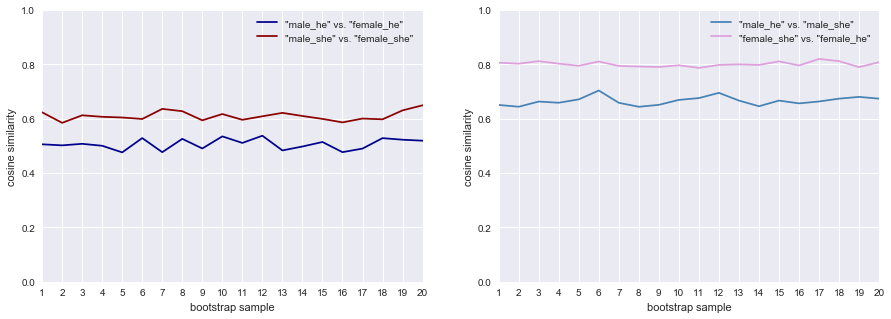

In [1237]:
s1= []
s2= []
s3= []
s4= []

for name, model in model_collection_dic.items():
    s1+= [cos_similarity(model, 'male_he', 'female_he')[0,0]]
    s2+= [cos_similarity(model, 'male_he', 'male_she')[0,0]]
    s3+= [cos_similarity(model, 'female_she', 'female_he')[0,0]]
    s4+= [cos_similarity(model, 'male_she', 'female_she')[0,0]]

f= plt.figure(figsize= (15, 5))

x= [i for i in range(1, 21)]

plt.subplot(121)
plt.plot(x, s1, 'darkblue', label='"male_he" vs. "female_he"')
plt.plot(x, s4, 'darkred',  label= '"male_she" vs. "female_she"')
plt.axis([1, 20, 0, 1])
plt.xticks(np.arange(1, 21, 1))
plt.ylabel("cosine similarity")
plt.xlabel("bootstrap sample")
plt.legend()



plt.subplot(122)
plt.plot(x, s2, "steelblue", label= '"male_he" vs. "male_she"')
plt.plot(x, s3, 'plum',  label= '"female_she" vs. "female_he"')
plt.axis([1, 20, 0, 1])
plt.xticks(np.arange(1, 21, 1))
plt.ylabel("cosine similarity")
plt.xlabel("bootstrap sample")
plt.legend()


In [1288]:
#Proceed with model7
#bookW2V_20= model_collection_dic["model7"]

"""Already calculated and saved the 20 models. Load one of them"""
bookW2V_20= gensim.models.Word2Vec.load("model3.model") 

In [1289]:
#Now I want to look for the most similar words of a kind for a target word 
def most_similar_word(model, target_word, tag_list, howmany= 50, word_tag_dic= word_tag_dic):
    #Input 1: the word2vec model 
    #Input 2: target word that I want to look for similar words for 
    #Input 3: tag_list. Do I want to see the similar noun, adj, or v or ...?
    #Input 4: how many most similar words I want
    #Input 5: optional. This is the dictionary that gives each word its attributes
    
    similar_word_list= model.wv.most_similar(target_word, topn= 5000)
    found_most_similar= []
    for sim, num in similar_word_list:
        try:
            """Human names are difficult to handle and jieba gives names different tags. 
            Since I really do not want any names. I add one more filter here to 
            screen out anything that could be names"""
            if ("nr" not in word_tag_dic[sim]) and ("nrfg" not in word_tag_dic[sim]):
                if set(word_tag_dic[sim])& set(tag_list)!= set():
                    found_most_similar+= [sim]
        except:
            pass
    return found_most_similar[:howmany]
    
    
keep_tag_adj= ["a", "ag", "ad", "an", "z"] # "i"
keep_tag_v= ["vg", "v", "vd", "vn"]
keep_tag_n= ["n", "ns", "ng"]
keep_tag= keep_tag_adj+ keep_tag_v

#print("most similar adj:", most_similar_word(bookW2V_20, "male_he", keep_tag_adj, 150))


def all_model_similary_word_count(target_word, tag_list, howmany= 50, word_tag_dic= word_tag_dic):
    #This function utilizes the most_similar_word function defines above
    #The previous function turns the most similar words of a specified kind of one mode
    #This function complile the most similar words the the 20 bootstrap models
    output_dic= {}
    for name, model in model_collection_dic.items():   
        most_similar_1= most_similar_word(model, target_word, tag_list, howmany= howmany, word_tag_dic= word_tag_dic)
        for sw in most_similar_1:
            if sw not in output_dic:
                output_dic[sw]= 1
            else:
                output_dic[sw]+= 1
    return output_dic

male_he_20= all_model_similary_word_count("male_he", keep_tag_adj, 50)
male_he_20_sorted= sorted(male_he_20.items(), key=operator.itemgetter(1), reverse=True)
print("male_he:", len(male_he_20), male_he_20_sorted[:50])
male_he_20_tot= [w for w, n in male_he_20_sorted[:60]]
print()

male_she_20= all_model_similary_word_count("male_she", keep_tag_adj, 50)
male_she_20_sorted= sorted(male_she_20.items(), key=operator.itemgetter(1), reverse=True)
print("male_she:", len(male_she_20), male_she_20_sorted[:50])
male_she_20_tot= [w for w, n in male_she_20_sorted[:60]]
print()

female_he_20= all_model_similary_word_count("female_he", keep_tag_adj, 50)
female_he_20_sorted= sorted(female_he_20.items(), key=operator.itemgetter(1), reverse=True)
print("female_he:", len(female_he_20), female_he_20_sorted[:50])
female_he_20_tot= [w for w, n in female_he_20_sorted[:80]]
print()

female_she_20= all_model_similary_word_count("female_she", keep_tag_adj, 50)
female_she_20_sorted= sorted(female_she_20.items(), key=operator.itemgetter(1), reverse=True)
print("female_she:", len(female_she_20), female_she_20_sorted[:50])
female_she_20_tot= [w for w, n in female_she_20_sorted[:80]]
print()


male_he: 177 [('完全', 20), ('根本', 20), ('危险', 20), ('正确', 20), ('显然', 20), ('直接', 20), ('成功', 20), ('容易', 20), ('清楚', 20), ('确实', 20), ('痛苦', 20), ('努力', 20), ('彻底', 20), ('强', 20), ('简单', 20), ('明显', 20), ('重要', 20), ('难', 20), ('轻易', 20), ('困难', 19), ('强大', 19), ('愚蠢', 18), ('认真', 18), ('强烈', 15), ('突然', 15), ('绮丽', 14), ('冷静', 14), ('严重', 14), ('甜甜', 14), ('最好', 14), ('意外', 14), ('糟糕', 13), ('早', 11), ('具体', 11), ('厉害', 10), ('轻松', 10), ('黑脚', 9), ('乐乐', 9), ('怕死', 9), ('幼稚', 9), ('单纯', 9), ('神秘', 9), ('纯粹', 9), ('邪', 8), ('恐惧', 8), ('神秀', 8), ('固执', 8), ('极限', 8), ('不对', 7), ('郁闷', 7)]

male_she: 225 [('温柔', 20), ('单纯', 20), ('害羞', 20), ('完全', 20), ('认真', 20), ('漂亮', 20), ('根本', 20), ('不好意思', 19), ('容易', 18), ('努力', 18), ('清纯', 17), ('亲爱', 16), ('善良', 16), ('胆小', 16), ('绮丽', 15), ('倔强', 15), ('愚蠢', 14), ('甜甜', 14), ('年轻', 14), ('坚决', 13), ('婉', 12), ('显然', 12), ('确实', 12), ('柔弱', 12), ('勇敢', 12), ('刁定', 12), ('潇潇', 11), ('冷静', 11), ('固执', 11), ('娟子', 10), ('灵静', 10), ('明显', 10), ('琅

In [1266]:
def chi_to_eng(wordlist):
    translator = Translator()
    
    chi_eng_dic= {}
    
    for chi_w in wordlist:
        try:
            eng_w= translator.translate(chi_w).text
            chi_eng_dic[chi_w]= eng_w
        except:
            print("something is wrong:", chi_w)
    return chi_eng_dic

male_he_20_eng= chi_to_eng(male_he_20_tot)
male_she_20_eng= chi_to_eng(male_she_20_tot)
female_he_20_eng= chi_to_eng(female_he_20_tot)
female_she_20_eng= chi_to_eng(female_she_20_tot)

In [1269]:
def print_translate(a_dic):
    for_print= []
    for chi, eng in a_dic.items():
        for_print+= [chi+str("-")+eng]
    return for_print

print(print_translate(male_he_20_eng))

['完全-complete', '根本-fundamental', '危险-Danger', '正确-correct', '显然-Obviously', '直接-direct', '成功-success', '容易-easy', '清楚-clear', '确实-indeed', '痛苦-pain', '努力-Work hard', '彻底-thorough', '强-Strong', '简单-simple', '明显-obvious', '重要-important', '难-difficult', '轻易-easily', '困难-difficult', '强大-powerful', '愚蠢-silly', '认真-serious', '强烈-strong', '突然-suddenly', '绮丽-beautiful', '冷静-calm', '严重-serious', '甜甜-Sweet', '最好-the best', '意外-accident', '糟糕-bad', '早-early', '具体-specific', '厉害-Powerful', '轻松-Relaxed', '黑脚-Black feet', '乐乐-Lele', '怕死-fear death', '幼稚-naive', '单纯-simple', '神秘-mysterious', '纯粹-purely', '邪-evil', '恐惧-fear', '神秀-God show', '固执-stubborn', '极限-limit', '不对-wrong', '郁闷-depressed', '宁缺-Ning deficiency', '荒诞-absurd', '不错-Good', '野蛮-brutal', '刁定-刁定', '鬼-ghost', '神奇-magical', '蠢-stupid', '清醒-wide awake', '成真-Accomplishment']


In [1023]:
def intrinsic_similarity(model, wordlist):
    np_2dim= np.empty((len(wordlist), len(wordlist)))
    for i in range(np_2dim.shape[0]):
        for j in range(np_2dim.shape[1]):
            np_2dim[i, j]= cos_similarity(model, wordlist[i], wordlist[j])
    return np_2dim

In [1025]:
for name, model in model_collection_dic.items():
    print(name)
    male_he_adj= most_similar_word(model, "male_he", keep_tag_adj, 50)
    male_she_adj= most_similar_word(model, "male_she", keep_tag_adj, 50)
    female_he_adj= most_similar_word(model, "female_he", keep_tag_adj, 50)
    female_she_adj= most_similar_word(model, "female_she", keep_tag_adj, 50)

    print("   male_he", intrinsic_similarity(model, male_he_adj).mean())

    print("   male_she", intrinsic_similarity(model, male_she_adj).mean())

    print("   female_he",intrinsic_similarity(model, female_he_adj).mean())

    print("   female_she", intrinsic_similarity(model, female_she_adj).mean())


model0
   male_he 0.1548450701791793
   male_she 0.12992561542391778
   female_he 0.10953017401471735
   female_she 0.10077668541148305
model1
   male_he 0.14374223508127035
   male_she 0.12017817310579121
   female_he 0.10996891061477364
   female_she 0.11382477054074407
model2
   male_he 0.1443182529296726
   male_she 0.10853603831864893
   female_he 0.10536316033266485
   female_she 0.10959156139735132
model3
   male_he 0.14874518097266554
   male_she 0.11163372479379177
   female_he 0.1068609601251781
   female_she 0.11981877289693803
model4
   male_he 0.1448295814961195
   male_she 0.11787524384260177
   female_he 0.1024559476049617
   female_she 0.11241424000300466
model5
   male_he 0.14995199616737664
   male_she 0.1234085296086967
   female_he 0.12142848567590117
   female_she 0.10945057034678757
model6
   male_he 0.1521659443117678
   male_she 0.11723349701836705
   female_he 0.11351330898925661
   female_she 0.10703292510583996
model7
   male_he 0.14191939700841905
   male_sh

In [1026]:
#Overlap between the similar words
male_he_10= most_similar_word(bookW2V_20, "male_he", keep_tag, 150)
male_she_10= most_similar_word(bookW2V_20, "male_she", keep_tag, 150)
female_he_10= most_similar_word(bookW2V_20, "female_he", keep_tag, 150)
female_she_10= most_similar_word(bookW2V_20, "female_she", keep_tag, 150)

print(len(set(male_he_10)& set(male_she_10)))
print(len(set(female_he_10)& set(female_she_10)))

56
89


Intermezzo: to test the order effect of the dataset 

In [55]:
#What if I use other words ranther than "他" and "她"?
#For the word "脸庞", it the order of the novels doesn't really matter. 
#For the word "温柔", the order has some effect. But not as much for "她" and "他"

def replace_testing_maleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "脸庞":
            new_wordlist+= ["male_脸"]
        elif w== "温柔":
            new_wordlist+= ["male_温"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]
        
def replace_testing_femaleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "脸庞":
            new_wordlist+= ["female_脸"]
        elif w== "温柔":
            new_wordlist+= ["female_温"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]

bookDF_ch["testing_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: replace_testing_maleN(x)),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: replace_testing_femaleN(x))],
                                        axis= 0)

#=============
bookW2V_testing= gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                           alpha=0.025,
                                           window=5,
                                           min_count=10,
                                           hs=0,  #hierarchical softmax toggle
                                           compute_loss = True)
#sampA= bookDF_ch["testing_replace"].iloc[:500].sample(frac=1, replace=False).sum()
#sampB= bookDF_ch["testing_replace"].iloc[500:].sample(frac=1, replace=False).sum()
bookW2V_testing.build_vocab(bookDF_ch["testing_replace"].sum())
bookW2V_testing.train(bookDF_ch["testing_replace"].sum(), 
              total_examples= bookW2V_testing.corpus_count, 
              epochs=10)

print(cos_similarity(bookW2V_testing, 'male_脸', 'female_脸'))
print(cos_similarity(bookW2V_testing, 'male_温', 'female_温'))
print()
#=============

bookW2V_Sotesting= gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                           alpha=0.025,
                                           window=5,
                                           min_count=10,
                                           hs=0,  #hierarchical softmax toggle
                                           compute_loss = True)
#sampA= bookDF_ch["testing_replace"].iloc[:500].sample(frac=1, replace=False).sum()
#sampB= bookDF_ch["testing_replace"].iloc[500:].sample(frac=1, replace=False).sum()
bookW2V_Sotesting.build_vocab(bookDF_ch["testing_replace"].sum())
bookW2V_Sotesting.train(sorted(bookDF_ch["testing_replace"].sum()), 
              total_examples= bookW2V_Sotesting.corpus_count, 
              epochs=10)

print(cos_similarity(bookW2V_Sotesting, 'male_脸', 'female_脸'))
print(cos_similarity(bookW2V_Sotesting, 'male_温', 'female_温'))



[[0.90458983]]
[[0.7773516]]

[[0.86085105]]
[[0.6992688]]


#### An alternative way

In [703]:
bookDF_ch["30_ch_list_not_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: [x]),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: [x])],
                                        axis= 0)

In [1083]:
two_tar= ["他", "她"]
two_tar_dicofDF= {tar: pd.DataFrame({}) for tar in two_tar}


bookW2V_altern = gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                              alpha=0.025,
                                              window=5,
                                              min_count=10,
                                              hs=0,  #hierarchical softmax toggle
                                            compute_loss = True)

#sampA and sampB are the original dataset (not bootstrapped); 
#I .sample() to randomize the 500 novels so that they are not ordered by popularity
sampA= bookDF_ch["30_ch_list_not_replace"].iloc[:500].sample(frac=1, replace=False).sum()
sampB= bookDF_ch["30_ch_list_not_replace"].iloc[500:].sample(frac=1, replace=False).sum()
bookW2V_altern.build_vocab(sampA+ sampB)
for e in range(300):
    bookW2V_altern.train(sampA, total_examples= 500, start_alpha=0.025, epochs=1)
    for tar in two_tar:
        tar_vector= pd.DataFrame(bookW2V_altern.wv[tar]).T #Transpose a column to a row
        two_tar_dicofDF[tar]= two_tar_dicofDF[tar].append(tar_vector)
        
    bookW2V_altern.train(sampB, total_examples= 500, start_alpha=0.025, epochs=1)
    for tar in two_tar:
        tar_vector= pd.DataFrame(bookW2V_altern.wv[tar]).T #Transpose a column to a row
        two_tar_dicofDF[tar]= two_tar_dicofDF[tar].append(tar_vector)
        

In [1091]:
two_tar_dicofDF["他"].to_csv("bookW2V_altern他.csv")
two_tar_dicofDF["她"].to_csv("bookW2V_altern她.csv")

In [1235]:
bookW2V_altern.wv.syn0.shape

(102393, 200)

500 male novels (epoch 1), then 500 female novels (epoch 2), then 500 male novels (epoch 3), then 500 female (epoch 4) and so on for 600 epochs in total. 

The blue line is similarity between "he" verctor of one epoch and "he" verctor of the previous epoch; the red line is similarity between "she" verctor of one epoch and "she" verctor of the previous epoch. The lower the similarity socre between consecutive epochs, the more surprised the model is. As shown in the graph below, the entire "he" line is below the "she" line. This means that the model more surprised about the context of "he" when the model alternates between male and female novels.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


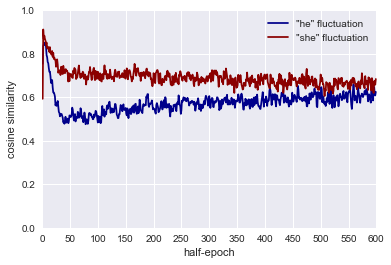

In [1272]:
def fluctuation_from_previous(a_DF):
    #Input is an epoch * dimension dataframe
    re_DF= a_DF.reset_index()
    output_sim_list= []
    for ind in range(re_DF.shape[0]):
        if ind == 0:
            previous= re_DF.iloc[0]
            
        else:
            current= re_DF.iloc[ind]
           
            output_sim_list+= \
            [sklearn.metrics.pairwise.cosine_similarity(previous.reshape(1,-1), current.reshape(1,-1))[0][0]]
            previous= current
    return output_sim_list

he_fluctuation= fluctuation_from_previous(two_tar_dicofDF["他"])
she_fluctuation= fluctuation_from_previous(two_tar_dicofDF["她"])


x= [i for i in range(1, 600)]    


plt.plot(x, he_fluctuation, 'darkblue', label='"he" fluctuation')
plt.plot(x, she_fluctuation, "darkred", label= '"she" fluctuation')
plt.axis([0, 601, 0, 1])
plt.xticks(np.arange(0, 601, 50))
plt.ylabel("cosine similarity")
plt.xlabel("half-epoch")
plt.legend()

Ploting words on a gender dimension

In [1290]:
#words to create dimensions
tnytTargetWords = ["female_he", "female_she" , 'male_he', "male_she"]
#

#words we will be mapping
tnytTargetWords += ["善良", "冷酷", 
                    "温柔", "粗暴",  
                    "强大", 
                    "残暴",
                    "柔软", "坚硬", 
                    "纯净",  
                    "心软", "强硬",
                    "痛苦", "欢乐", 
                    "悲惨", "幸福", 
                    "嫉妒", "妒忌", 
                    "宽恕", "豁达", 
                    "贪婪", 
                    "惧怕", 
                    "支撑", 
                    "轻松", "沉重", 
                    "忧伤", "从容", 
                    "喜欢", 
                    "柔弱", "强壮", 
                    "清纯", "老道"]
target_dic= {"male_he": "male_he", "male_she": "male_she", "female_he": "female_he", "female_she": "female_she", 
             "善良": "kind", "冷酷": "cold-blooded", 
             "温柔": "gentle", 
             "粗暴": "rude", 
             "强大": "strong", "柔软": "soft", "坚硬": "hard", "纯净": "pure", 
             "残暴": "brutal", "心软": "soft-hearted", "强硬": "tough",
             "开心": "happy", "难过": "sad", "痛苦": "painful", "欢乐": "joy", 
             "悲惨": "miserable", "幸福": "hapiness", "嫉妒": "jealous", "妒忌": "envious", 
             "宽恕": "forgive", "豁达": "generous", "贪婪": "greedy", "惧怕": "fear", 
             "支撑": "support", "轻松": "relaxing", "沉重": "heavy", "忧伤": "sorrow", 
             "从容": "unhurried", "喜欢": "like", "动": "moving", "静": "still", 
             "柔弱": "delicate", "强壮": "robust", "清纯": "innocent", "老道": "seasoned",
             "成熟": "mature", "幼稚": "immature", "哭": "cry", "笑": "smile",
             "高手": "master", "新手": "newbie"}


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(bookW2V_20.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.18460079,  0.49904427,  1.5926014 , ...,  0.7852894 ,
         2.9510896 ,  0.84896743],
       [ 0.20671488, -0.18960692,  2.363801  , ...,  0.6791583 ,
         1.6088402 , -0.33376583],
       [ 1.1217331 , -0.3688375 , -0.07849975, ...,  1.3457477 ,
         1.5685208 , -1.375219  ],
       ...,
       [ 2.1345487 ,  1.1804278 , -0.94299996, ...,  1.421387  ,
         5.657922  , -0.0867824 ],
       [ 3.37601   , -2.411012  , -0.61300266, ..., -1.0828315 ,
         3.057328  ,  1.4912338 ],
       [-1.1188415 , -4.4074726 , -1.8513417 , ..., -1.2511324 ,
         5.2649016 ,  0.84828186]], dtype=float32)

In [1291]:
target_english= [target_dic[w] for w in tnytTargetWords]
print(target_english)

['female_he', 'female_she', 'male_he', 'male_she', 'kind', 'cold-blooded', 'gentle', 'rude', 'strong', 'brutal', 'soft', 'hard', 'pure', 'soft-hearted', 'tough', 'painful', 'joy', 'miserable', 'hapiness', 'jealous', 'envious', 'forgive', 'generous', 'greedy', 'fear', 'support', 'relaxing', 'heavy', 'sorrow', 'unhurried', 'like', 'delicate', 'robust', 'innocent', 'seasoned']


In [1292]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [1293]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [1294]:
cos_similarity(bookW2V_20, "female_he", "男")

array([[0.24989639]], dtype=float32)

In [1295]:
#If I just want a gender dimension and do not care whether the gender words in male or female novel
#I can just add them here
gender = dimension(bookW2V_20, 
                   ["male_he", "female_he", "男", "男人", "男孩", "少年", "小男孩"], 
                   ["male_she", "female_she", "女", "女人", "女孩", "少女", "小女孩"])  



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [1296]:
def makeDF(model, word_list):
    g = []
    
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(bookW2V_20[word].reshape(1,-1), gender.reshape(1,-1))[0][0])
    
    df = pd.DataFrame({'gender': g}, index = target_english)
    return df

In [1297]:
adjectiveDF = makeDF(bookW2V_20, tnytTargetWords)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [1298]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.flag(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    #ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

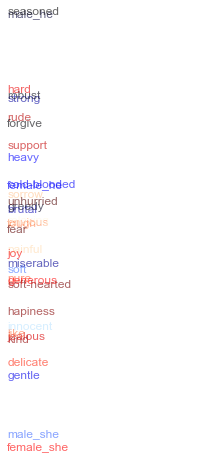

In [1299]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, adjectiveDF, 'gender')
plt.show()

In the previous section, I graph network (in Gephi) to describe the novels. I could not graph with the four gender words in the network because they are associated with almost every other words and separate the nework into clear clusters centering around them. However, I can examine the network statistics of the four gender words, the result of which confirm the findings of the word embedding. 

In [ ]:
#Following the code above
target_4= list(target_3+ gender_target)
adjacencyM_4, target_dic_4, target_dic_rev_4= cal_adjacencyM(bookDF_ch, "30_ch_list_replace", target_4)

node_node_w_4= []
for i in range(adjacencyM_4.shape[0]):
    for j in range(i, adjacencyM_4.shape[0]):
        if adjacencyM_4[i, j]> 0:
            node_node_w_4+= [(target_dic_rev_4[i], 
                              target_dic_rev_4[j], 
                              adjacencyM_4[i, j])]
            


In [736]:
g_4= nx.Graph()
g_4.add_weighted_edges_from(node_node_w_4)

print(nx.info(g_4))

#Average weight
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_4.edges(data = True)]))
print("Median weight:", np.median([d["weight"] for n1, n2, d in g_4.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 197922
Average degree: 395.8440
Average weight: 7.652282212184598
Median weight: 2.0


I plot a graph that shows how the centrality value of the 4 gender words change as I trim the network based on centrality.

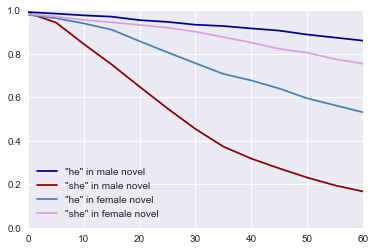

In [737]:
male_he_trim= []
male_she_trim= []
female_he_trim= []
female_she_trim= []

trim_weight= [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]



for w in trim_weight:
    g_4.remove_edges_from([(n1, n2) for n1, n2, d in g_4.edges(data = True) if d['weight'] <= w])
    
    dcentralities = nx.degree_centrality(g_4)
    male_he_trim+= [dcentralities['male_he']]
    male_she_trim+= [dcentralities['male_she']]
    female_he_trim+= [dcentralities['female_he']]
    female_she_trim+= [dcentralities['female_she']]


sns.set()
plt.plot(trim_weight, male_he_trim, 'darkblue', label='"he" in male novel')
plt.plot(trim_weight, male_she_trim, 'darkred', label='"she" in male novel')
plt.plot(trim_weight, female_he_trim, 'steelblue',  label='"he" in female novel')
plt.plot(trim_weight, female_she_trim, 'plum',  label='"she" in female novel')
plt.axis([0, 60, 0, 1])
plt.legend()

**Step 10. Classification**

*Classification.1*: I use only the gender words to do the classification, which means 14 features: "她" she, "他" he, "女孩" girl, "小女孩" little, "男孩" boy, "小男孩" little boy, "女人" woman, "男人" man, "女" female, "男" male, "少年" teenage boy, "少女" teenage girl, "男子" man, "女子" woman. This should have a higher-than-chance accuracy because the occurence of these characters are different in male and female novels.

In [56]:
col= ["ch"+str(i)+"_clean" for i in range(1,31)]

bookDF_both= pd.concat([bookDF_male_tokenized[col], bookDF_female_tokenized[col]], axis= 0)
bookDF_both["gender"]= [1]*500+ [0]*500
#bookDF_both

In [57]:
#Collapse the 30 chapters
collapsed_ch_1000= []
for i in range(bookDF_both.shape[0]):
    a_book= bookDF_both.iloc[i]
    collapsed_ch= []
    for c in col:
        collapsed_ch+= a_book[c]
    collapsed_ch_1000+= [collapsed_ch]  

In [62]:
target= ["她", "他", "女孩", "小女孩", "男孩", "小男孩", 
         "女人", "男人", "女", "男", "少年", "少女", "男子", "女子"]

#target= ["她", "女孩", "小女孩",
#         "女人", "女", "少女"]

#target= ["他" "男孩", "小男孩", 
#         "男人", "男", "少年"]

In [63]:
#Get the 5-word windows next to the target words. 
#This is NOT ideal! There are repetitions! 
#For example, if 她 and 他 occur close to each other, the code below  
#would get a window for 她 and another window for 他, which results in repetition.
def get_target_window(target):
    #Input: target is a list of target words
    w= 5
    windows_1000= []
    for book in collapsed_ch_1000:
        windows= []
        for i in range(len(book)):
            if book[i] in target:
                if i< w: #This is for the first 5 (window) words
                    window= book[0: i+w+1]
                    windows+= window
                else:
                    window= book[i-w:i+w+1]
                    windows+= window
        windows_1000+= [windows]
    len(windows_1000)

    clf_DF= pd.DataFrame({"gender_words": windows_1000})
    clf_DF["gender"]= [1]*500+ [0]*500
    clf_DF["gender_string"]= clf_DF["gender_words"].apply(lambda x: " ".join(x))
    return clf_DF

clf_DF= get_target_window(target)

In [67]:
#10-fold cross validation--classification based on the occurence of the 14 gender words
def cross_val_target(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    
    train_precision= []
    test_precision= []
    
    train_recall= []
    test_recall= []
    
    train_f1= []
    test_f1= []
    
    kf = KFold(n_splits=10, shuffle= True)
    
    for train_index, test_index in kf.split(X):

        X_train_string, X_test_string = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        vectorizer= sklearn.feature_extraction.text.CountVectorizer(vocabulary= ["她", "他", 
                                                                                 "女孩", "小女孩", 
                                                                                 "男孩", "小男孩", 
                                                                                 "女人", "男人", 
                                                                                 "女", "男", 
                                                                                 "少年", "少女",
                                                                                 "男子", "女子"])
        X_train_wordfeq= vectorizer.fit_transform(X_train_string)
        X_test_wordfeq= vectorizer.transform(X_test_string)
    
        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train_wordfeq, y_train)
        
        y_train_pred= clf.predict(X_train_wordfeq)
        y_test_pred= clf.predict(X_test_wordfeq)
        
        ##Accuracy score of training and test set
        
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
        
        ##Precision score of training and test set
        train_precision+= [precision_score(y_train, y_train_pred)]
        test_precision+= [precision_score(y_test, y_test_pred)]
        
        ##Recall score of training and test set
        train_recall+= [recall_score(y_train, y_train_pred)]
        test_recall+= [recall_score(y_test, y_test_pred)]
        
        ##F1 score of training and test set
        train_f1+= [f1_score(y_train, y_train_pred)]
        test_f1+= [f1_score(y_test, y_test_pred)]
        
    summaryDF= pd.DataFrame({"train_accuracy": train_accuracy,
                             "test_accuracy": test_accuracy,
                             "train_precision": train_precision,
                             "test_precision": test_precision,
                             "train_recall": train_recall,
                             "test_recall": test_recall,
                             "train_f1": train_f1,
                             "test_f1": test_f1})
    
    
    return summaryDF

X= clf_DF["gender_string"]
y= clf_DF["gender"]

clf_lr = sklearn.linear_model.LogisticRegression()
outcome_use_target= cross_val_target(X, y, clf_lr)
outcome_use_target

,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.73,0.752294,0.706897,0.803922,0.687778,0.709411,0.662162,0.763920
1,0.64,0.672727,0.587302,0.787234,0.704444,0.730223,0.675422,0.794702
2,0.80,0.803922,0.803922,0.803922,0.691111,0.715746,0.661626,0.779510
3,0.70,0.732143,0.694915,0.773585,0.704444,0.726899,0.671727,0.791946
4,0.60,0.607843,0.525424,0.720930,0.697778,0.726358,0.672253,0.789934
5,0.73,0.715789,0.708333,0.723404,0.687778,0.715299,0.661049,0.779249
6,0.67,0.702703,0.696429,0.709091,0.703333,0.721585,0.673152,0.777528
7,0.65,0.695652,0.655738,0.740741,0.705556,0.724818,0.675048,0.782511
8,0.64,0.660377,0.583333,0.760870,0.696667,0.723404,0.669794,0.786344
9,0.66,0.711864,0.646154,0.792453,0.704444,0.722917,0.676413,0.776286


In [73]:
outcome_use_target["test_accuracy"].mean()

0.682

*Classification.2*: Utilize the windows next to the gender words (the local context of the gender words). I perform the simple CountVectorizer to calculat the frequency of each words, then use PCA to extract features out of the plain word-frequency count. 



In [68]:
"""Testing phase with one split: """
#Which classifier works the best?
#How many PCA factors?

X_train_string, X_test_string, y_train, y_test= \
train_test_split(clf_DF["gender_string"], clf_DF["gender"], test_size= 0.1)

vectorizer= sklearn.feature_extraction.text.CountVectorizer()
X_train_wordfeq= vectorizer.fit_transform(X_train_string)
X_test_wordfeq= vectorizer.transform(X_test_string)

pca = sklearn.decomposition.PCA(n_components = 200)
X_train = pca.fit_transform(X_train_wordfeq.toarray())
X_test= pca.transform(X_test_wordfeq.toarray())

In [71]:
"""Testing phase with one split: """

clf_naive = sklearn.naive_bayes.GaussianNB()
clf_SVClinear = sklearn.svm.SVC(kernel = 'linear', probability = True) 
clf_SVCrbf = sklearn.svm.SVC(kernel = 'rbf', degree = 3, probability = True) 
clf_KNN = sklearn.neighbors.KNeighborsClassifier(6, weights='distance')
clf_lr = sklearn.linear_model.LogisticRegression()
clf_tree = sklearn.tree.DecisionTreeClassifier()
clf_forest = sklearn.ensemble.RandomForestClassifier()
clf_neural = sklearn.neural_network.MLPClassifier()
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()

clf_collection= {"clf_naive": clf_naive, "clf_lr": clf_lr,
                 "clf_SVClinear": clf_SVClinear,
                 "clf_SVCrbf": clf_SVCrbf, "clf_KNN": clf_KNN, "clf_tree": clf_tree,
                 "clf_forest": clf_forest, "clf_neural": clf_neural, 
                 "clf_ensemble": clf_ensemble}

for name, clf in clf_collection.items():      
        print("classifier:", name)     
        for i in [50, 100, 150, 200]:
            print(i)      
            clf.fit(X_train[:, :i], y_train)

            y_train_pred= clf.predict(X_train[:, :i])
            print("training's accuracy: ", accuracy_score(y_train, y_train_pred))

            y_test_pred= clf.predict(X_test[:, :i])
            print("testing's accuracy: ", accuracy_score(y_test, y_test_pred))
        print()  
#Decide to choose linear regression classify using 150 PCA components

classifier: clf_naive
50
training's accuracy:  0.6088888888888889
testing's accuracy:  0.5
100
training's accuracy:  0.6122222222222222
testing's accuracy:  0.48
150
training's accuracy:  0.6166666666666667
testing's accuracy:  0.48
200
training's accuracy:  0.6166666666666667
testing's accuracy:  0.47

classifier: clf_lr
50
training's accuracy:  0.9122222222222223
testing's accuracy:  0.87
100
training's accuracy:  0.9555555555555556
testing's accuracy:  0.93
150
training's accuracy:  0.98
testing's accuracy:  0.92
200
training's accuracy:  0.9966666666666667
testing's accuracy:  0.9

classifier: clf_SVClinear
50
training's accuracy:  0.9188888888888889
testing's accuracy:  0.86
100
training's accuracy:  0.9577777777777777
testing's accuracy:  0.94
150
training's accuracy:  0.9888888888888889
testing's accuracy:  0.94
200
training's accuracy:  1.0
testing's accuracy:  0.88

classifier: clf_SVCrbf
50
training's accuracy:  1.0
testing's accuracy:  0.43
100
training's accuracy:  1.0
test

In [72]:
def cross_val_pca(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    
    train_precision= []
    test_precision= []

    train_recall= []
    test_recall= []
    
    train_f1= []
    test_f1= []
    
    kf = KFold(n_splits=10, shuffle= True)
    
    for train_index, test_index in kf.split(X):

        X_train_string, X_test_string = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        vectorizer= sklearn.feature_extraction.text.CountVectorizer()
        X_train_wordfeq= vectorizer.fit_transform(X_train_string)
        X_test_wordfeq= vectorizer.transform(X_test_string)

        pca = sklearn.decomposition.PCA(n_components = 150)
        X_train = pca.fit_transform(X_train_wordfeq.toarray())
        X_test= pca.transform(X_test_wordfeq.toarray())
        
    
        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train, y_train)
        
        y_train_pred= clf.predict(X_train)
        y_test_pred= clf.predict(X_test)
        
        ##Accuracy score of training and test set
        
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
        
        ##Precision score of training and test set
        train_precision+= [precision_score(y_train, y_train_pred)]
        test_precision+= [precision_score(y_test, y_test_pred)]
        
        ##Recall score of training and test set
        train_recall+= [recall_score(y_train, y_train_pred)]
        test_recall+= [recall_score(y_test, y_test_pred)]
        
        ##F1 score of training and test set
        train_f1+= [f1_score(y_train, y_train_pred)]
        test_f1+= [f1_score(y_test, y_test_pred)]
        
    summaryDF= pd.DataFrame({"train_accuracy": train_accuracy,
                             "test_accuracy": test_accuracy,
                             "train_precision": train_precision,
                             "test_precision": test_precision,
                             "train_recall": train_recall,
                             "test_recall": test_recall,
                             "train_f1": train_f1,
                             "test_f1": test_f1})
    
    
    return summaryDF

X= clf_DF["gender_string"]
y= clf_DF["gender"]

outcome_use_pca= cross_val_pca(X, y, clf_lr)
outcome_use_pca

,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.94,0.938776,0.958333,0.920000,0.985556,0.985604,0.982340,0.988889
1,0.98,0.979592,0.960000,1.000000,0.981111,0.981215,0.980132,0.982301
2,0.92,0.916667,0.936170,0.897959,0.986667,0.986726,0.984547,0.988914
3,0.94,0.941176,0.905660,0.979592,0.978889,0.979052,0.973684,0.984479
4,0.94,0.948276,0.964912,0.932203,0.986667,0.986517,0.977728,0.995465
5,0.90,0.883721,0.808511,0.974359,0.988889,0.989201,0.984946,0.993492
6,0.91,0.914286,0.905660,0.923077,0.990000,0.989989,0.986696,0.993304
7,0.89,0.900901,0.943396,0.862069,0.985556,0.985377,0.979866,0.990950
8,0.91,0.912621,0.903846,0.921569,0.990000,0.990011,0.986726,0.993318
9,0.89,0.884211,0.840000,0.933333,0.990000,0.990121,0.989035,0.991209


In [74]:
outcome_use_pca["test_accuracy"].mean()

0.922

### Section 5 Emotion

***Section Overview***

I utilize a Chinese sentiment dictionary called dalian sentiment word list (http://ir.dlut.edu.cn/EmotionOntologyDownload). It contains 27466 Chinese words and categories them into one of 21 sentiment categories. 

In [ ]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

In [346]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)
bookDF_ch["book_gender"]= pd.DataFrame(["boy"]* 500+ ["girl"]*500)

"""
#Collapse 30 chapters
helper_lis= [] 
for i in range(bookDF_ch.shape[0]):
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_clean"]
    helper_lis+= [cell]

chDF_list= pd.DataFrame({"ch_list": helper_lis})
"""

'\n#Collapse 30 chapters\nhelper_lis= [] \nfor i in range(bookDF_ch.shape[0]):\n    cell= []\n    for j in range(30):\n        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_clean"]\n    helper_lis+= [cell]\n\nchDF_list= pd.DataFrame({"ch_list": helper_lis})\n'

In [347]:
dalian= pd.read_excel("dalian_sentiment_word.xlsx", encoding="latin-1")
print(dalian.columns)

dalian_dic= {}
for i in range(dalian.shape[0]):
    dalian_dic[dalian["词语"].iloc[i]]= \
    [dalian["极性"].iloc[i], dalian["强度"].iloc[i], dalian["情感分类"].iloc[i]]

Index(['词语', '词性种类', '词义数', '词义序号', '情感分类', '强度', '极性', '辅助情感分类', '强度.1',
       '极性.1', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')


In [348]:
emo_tag_list= ["PA", "PE", "PD", "PH", "PG", "PB", "PK",
               "NR", "NB", "NJ", "NH", "PF", "NI", "NC",
               "NG", "NE", "ND", "NN", "NK", "NL", "PC"]

In [349]:
"""Testing"""
tag= dalian_dic["愤怒"][2]
intense= dalian_dic["愤怒"][1]
ch_emo_dic= {"PA": 0, "PE": 0, "PD": 0, "PH": 0, 
             "PG": 0, "PB": 0, "PK": 0, "NR": 0, 
             "NB": 0, "NJ": 0, "NH": 0, "PF": 0, 
             "NI": 0, "NC": 0, "NG": 0, "NE": 0, 
             "ND": 0, "NN": 0, "NK": 0, "NL": 0, 
             "PC": 0}
ch_emo_dic[tag]+= intense

In [350]:
book_ch_emotion_DF= pd.DataFrame({})
for ind in range(bookDF_ch.shape[0]):
    book= bookDF_ch.iloc[ind]
    ch_emo_DF= pd.DataFrame({})
    for i in range(30):
        ch= book["ch"+ str(i+1)+ "_clean"]
        ch_emo_dic= {"chapter": i+1,
                     "PA": [0], "PE": [0], "PD": [0], "PH": [0], 
                     "PG": [0], "PB": [0], "PK": [0], "NR": [0], 
                     "NB": [0], "NJ": [0], "NH": [0], "PF": [0], 
                     "NI": [0], "NC": [0], "NG": [0], "NE": [0], 
                     "ND": [0], "NN": [0], "NK": [0], "NL": [0], 
                     "PC": [0]}
        for w in ch:
            if w in dalian_dic:
                tag= dalian_dic[w][2]
                intense= dalian_dic[w][1]
                
                """I normalize the emotion score by the length of the chapter"""
                ch_emo_dic[tag][0]+= intense/len(ch)

                     
        ch_emo_DF= ch_emo_DF.append(pd.DataFrame(ch_emo_dic))
        
    ch_emo_DF["book"]= ["book"+ str(ind)]*30
    #if ind== 0:
    #    print(ch_emo_DF)
    book_ch_emotion_DF= book_ch_emotion_DF.append(ch_emo_DF)
         

In [351]:
print(list(book_ch_emotion_DF.columns))

emotion_mean_total_raw= book_ch_emotion_DF.iloc[:, :21].sum(axis= 0)
emotion_mean_male_raw= book_ch_emotion_DF.iloc[:15000, :21].sum(axis= 0)
emotion_mean_female_raw= book_ch_emotion_DF.iloc[15000:, :21].sum(axis= 0)

emotion_mean_DF= pd.DataFrame({})
emotion_mean_DF["total_emo_raw"]= emotion_mean_total_raw
emotion_mean_DF["male_emo_raw"]= emotion_mean_male_raw
emotion_mean_DF["female_emo_raw"]= emotion_mean_female_raw
emotion_mean_DF

['NB', 'NC', 'ND', 'NE', 'NG', 'NH', 'NI', 'NJ', 'NK', 'NL', 'NN', 'NR', 'PA', 'PB', 'PC', 'PD', 'PE', 'PF', 'PG', 'PH', 'PK', 'chapter', 'book']


,total_emo_raw,male_emo_raw,female_emo_raw
NB,648.083354,305.120963,342.962391
NC,389.955204,233.170473,156.784731
ND,792.788023,429.005383,363.782640
NE,631.661377,287.470684,344.190693
NG,56.479196,24.871759,31.607437
NH,128.565918,54.089794,74.476125
NI,197.518157,94.286953,103.231204
NJ,198.439793,102.744623,95.695171
NK,16.708254,7.215954,9.492300
NL,206.666612,102.504677,104.161935


In [352]:
"""Testing"""
a= np.array([[1, 2, 3, 4], 
             [5, 6, 7, 8],
             [9, 10, 11, 12],
             [13, 14, 15, 16],
             [0, 8, 4, 2]])
(a- a.mean(axis= 0))/a.std(axis= 0)

array([[-0.94211671, -1.5       , -1.11803399, -0.85895569],
       [-0.12288479, -0.5       , -0.2236068 , -0.07808688],
       [ 0.69634713,  0.5       ,  0.67082039,  0.70278193],
       [ 1.51557905,  1.5       ,  1.56524758,  1.48365074],
       [-1.14692469,  0.        , -0.89442719, -1.2493901 ]])

In [353]:
t_test= scipy.stats.ttest_ind(book_ch_emotion_np_norm[:15000, 0], 
                                  book_ch_emotion_np_norm[15000:, 0])
[t_test.statistic]

[-11.267303054692732]

In [1276]:
#I first standardize each emotion by its column
#For each column, the 30000 cells sum up to 0
#Now the "important" emotions no longer overshadow the "unimportant" ones

emotion_col= list(book_ch_emotion_DF.columns)[:21]
print(emotion_col)

book_ch_emotion_np= np.array(book_ch_emotion_DF.iloc[:, :21])

book_ch_emotion_np_norm= \
(book_ch_emotion_np- book_ch_emotion_np.mean(axis= 0))/book_ch_emotion_np.std(axis= 0)

#T-test
emotion_key_dic= {"PA": "快乐", "PE": "安心", "PD": "尊敬", "PH": "赞扬",
                  "PG": "相信", "PB": "喜爱", "PK": "祝愿", "NR": "愤怒",
                  "NB": "悲伤", "NJ": "失望", "NH": "疚", "PF": "思",
                  "NI": "慌", "NC": "恐惧", "NG": "羞", "NE": "烦闷",
                  "ND": "憎恶", "NN": "贬责", "NK": "妒忌", "NL": "怀疑",
                  "PC": "惊奇"}

emotion_mean_male_norm= []
emotion_mean_female_norm= []
t_statistic_list= []
t_pvalue_list= []
chi_label= []

for i in range(len(emotion_col)):
    chi_label+= [emotion_key_dic[emotion_col[i]]]
    emotion_mean_male_norm+= [book_ch_emotion_np_norm[:15000, i].mean()]
    emotion_mean_female_norm+= [book_ch_emotion_np_norm[15000:, i].mean()]
    t_test= scipy.stats.ttest_ind(book_ch_emotion_np_norm[:15000, i], 
                                  book_ch_emotion_np_norm[15000:, i])
    t_statistic_list+= [t_test.statistic]
    t_pvalue_list+= [t_test.pvalue]


    
emotion_mean_DF["male_norm"]= emotion_mean_male_norm
emotion_mean_DF["female_norm"]= emotion_mean_female_norm
emotion_mean_DF["t_statistic"]= t_statistic_list
emotion_mean_DF["t_pvalue"]= t_pvalue_list
emotion_mean_DF["chi_label"]= chi_label
    
emotion_mean_DF.round(3).to_csv("emotion.csv")
emotion_mean_DF.round(3)


['NB', 'NC', 'ND', 'NE', 'NG', 'NH', 'NI', 'NJ', 'NK', 'NL', 'NN', 'NR', 'PA', 'PB', 'PC', 'PD', 'PE', 'PF', 'PG', 'PH', 'PK']


,total_emo_raw,male_emo_raw,female_emo_raw,male_norm,female_norm,t_statistic,t_pvalue,chi_label
NB,648.083,305.121,342.962,-0.065,0.065,-11.267,0.000,悲伤
NC,389.955,233.170,156.785,0.159,-0.159,27.855,0.000,恐惧
ND,792.788,429.005,363.783,0.077,-0.077,13.299,0.000,憎恶
NE,631.661,287.471,344.191,-0.114,0.114,-19.794,0.000,烦闷
NG,56.479,24.872,31.607,-0.054,0.054,-9.428,0.000,羞
NH,128.566,54.090,74.476,-0.086,0.086,-14.934,0.000,疚
NI,197.518,94.287,103.231,-0.033,0.033,-5.773,0.000,慌
NJ,198.440,102.745,95.695,0.025,-0.025,4.324,0.000,失望
NK,16.708,7.216,9.492,-0.025,0.025,-4.276,0.000,妒忌
NL,206.667,102.505,104.162,-0.006,0.006,-1.047,0.295,怀疑


Using the table above to test positivity bias

In [380]:
pos_emo= ['PA', 'PB', 'PC', 'PD', 'PE', 'PF', 'PG', 'PH', 'PK']
neg_emo= ['NB', 'NC', 'ND', 'NE', 'NG', 'NH', 'NI', 'NJ', 'NK', 'NL', 'NN', 'NR']

pos_emotion_mean_DF= emotion_mean_DF.loc[pos_emo, :]
neg_emotion_mean_DF= emotion_mean_DF.loc[neg_emo, :]

print("positive emotion sum")
print(pos_emotion_mean_DF.iloc[:, :3].sum(axis= 0))
print()

print("negative emotion sum")
print(neg_emotion_mean_DF.iloc[:, :3].sum(axis= 0))

#indeed positive emotion occurs more than negative emotion in both male and female novels


positive emotion sum
total_emo_raw     8989.756236
male_emo_raw      4669.454577
female_emo_raw    4320.301658
dtype: float64

negative emotion sum
total_emo_raw     5745.620163
male_emo_raw      2910.994160
female_emo_raw    2834.626003
dtype: float64


Emotions that he and she associated with

In [381]:
len(dalian_dic)

27351

In [554]:
col= ["ch"+str(i)+"_clean" for i in range(1,31)]

bookDF_both_forEmo= pd.concat([bookDF_male_tokenized[col], bookDF_female_tokenized[col]], axis= 0)
bookDF_both_forEmo["gender"]= [1]*500+ [0]*500
#bookDF_both_forEmo

In [555]:
for book in bookDF_both_forEmo:
    print(book)
    break

ch1_clean


In [386]:
"""
#Collapse the 30 chapters
collapsed_ch_1000= []
for i in range(bookDF_both.shape[0]):
    a_book= bookDF_both.iloc[i]
    collapsed_ch= []
    for c in col:
        collapsed_ch+= a_book[c]
    collapsed_ch_1000+= [collapsed_ch]  
"""

In [393]:
def get_target_window_dalian(target_male, target_female):
    #Input: target is a list of target words
    w= 5
    windows_1000_male= []
    windows_1000_female= []
    for book in collapsed_ch_1000:
        windows_male= []
        windows_female= []
        for i in range(len(book)):
            if book[i] in target_male:
                if i< w: #This is for the first 5 (window) words
                    window= book[0: i+w+1]
                    windows_male+= window
                else:
                    window= book[i-w:i+w+1]
                    windows_male+= window
            elif book[i] in target_female:
                if i< w: #This is for the first 5 (window) words
                    window= book[0: i+w+1]
                    windows_female+= window
                else:
                    window= book[i-w:i+w+1]
                    windows_female+= window
                
                
        windows_1000_male+= [windows_male]
        windows_1000_female+= [windows_female]
    
    
    around_heshe_DF= pd.DataFrame({"he_words": windows_1000_male, 
                                   "she_words": windows_1000_female})
    around_heshe_DF["gender"]= [1]*500+ [0]*500
    
    return around_heshe_DF

around_heshe_DF= get_target_window_dalian(["他"], ["她"])

In [570]:
def count_heshe_emotion_ch(input_DF, column_name):
    output_ch_DF= pd.DataFrame({})
    for ind in range(input_DF.shape[0]): 
        heshe_emo_dic= {"PA": [0], "PE": [0], "PD": [0], "PH": [0], 
                        "PG": [0], "PB": [0], "PK": [0], "NR": [0], 
                        "NB": [0], "NJ": [0], "NH": [0], "PF": [0], 
                        "NI": [0], "NC": [0], "NG": [0], "NE": [0], 
                        "ND": [0], "NN": [0], "NK": [0], "NL": [0], 
                        "PC": [0]}
        
        gender_words= input_DF[column_name].iloc[ind]
        #print(len(gender_words))
        for w in gender_words: 
            if w in dalian_dic:
                #print(w)
                tag= dalian_dic[w][2]
                intense= dalian_dic[w][1]
                
                """I normalize the emotion score by the length of selected words (sum of windows)"""
                heshe_emo_dic[tag][0]+= intense/len(gender_words)
        
        ch_DF= pd.DataFrame(heshe_emo_dic)
        
        output_ch_DF= output_ch_DF.append(ch_DF)

    return output_ch_DF

male_he_emo_ch= count_heshe_emotion_ch(around_heshe_DF.iloc[:500, :], "he_words")
male_she_emo_ch= count_heshe_emotion_ch(around_heshe_DF.iloc[:500, :], "she_words")


female_he_emo_ch= count_heshe_emotion_ch(around_heshe_DF.iloc[500:, :], "he_words")
female_she_emo_ch= count_heshe_emotion_ch(around_heshe_DF.iloc[500:, :], "she_words")




In [496]:
pos_emo= ['PA', 'PB', 'PC', 'PD', 'PE', 'PF', 'PG', 'PH', 'PK']
neg_emo= ['NB', 'NC', 'ND', 'NE', 'NG', 'NH', 'NI', 'NJ', 'NK', 'NL', 'NN', 'NR']

print("positive emotion:")
heshe_pos_emotion_DF= heshe_emotion_DF.loc[pos_emo, :]
print(heshe_pos_emotion_DF.sum(axis= 0))
print()

print("negative emotion:")
heshe_neg_emotion_DF= heshe_emotion_DF.loc[neg_emo, :]
print(heshe_neg_emotion_DF.sum(axis= 0))



positive emotion:
male_he_words       145.121097
male_she_words      152.725948
female_he_words     140.755896
female_she_words    135.069811
dtype: float64

negative emotion:
male_he_words       101.454096
male_she_words      100.149305
female_he_words     102.183678
female_she_words    101.404935
dtype: float64


In [699]:
#At book level. For the positive and negative emotions, T-test between four pairs: 

##1. "male_he" and "female_he"
##2. "male_she" and "female_she"

##3. "male_he" and "male_she"
##4. "female_he" and "female_she"

pos_emo= ['PA', 'PB', 'PC', 'PD', 'PE', 'PF', 'PG', 'PH', 'PK']
male_he_pos= male_he_emo_ch.loc[:, pos_emo].sum(axis= 0)
male_she_pos= male_she_emo_ch.loc[:, pos_emo].sum(axis= 0)
female_he_pos= female_he_emo_ch.loc[:, pos_emo].sum(axis= 0)
female_she_pos= female_she_emo_ch.loc[:, pos_emo].sum(axis= 0)

t_Mhe_Fhe_pos= scipy.stats.ttest_ind(male_he_pos, female_he_pos)
t_Mshe_Fshe_pos= scipy.stats.ttest_ind(male_she_pos, female_she_pos)
t_Mhe_Mshe_pos= scipy.stats.ttest_ind(male_he_pos, male_she_pos)
t_Fhe_Fshe_pos= scipy.stats.ttest_ind(female_he_pos, female_she_pos)

t_pos_dic= {"male_he_sum": male_he_pos.sum(),
            "male_she_sum": male_she_pos.sum(),
            "female_he_sum": female_he_pos.sum(),
            "female_she_sum": female_she_pos.sum(),
                    
            "Mhe_vs_Fhe_ST": [t_Mhe_Fhe_pos.statistic],
            "Mshe_vs_Fshe_ST": [t_Mshe_Fshe_pos.statistic],
            "Mhe_vs_Mshe_ST": [t_Mhe_Mshe_pos.statistic],
            "Fhe_vs_Fshe_ST": [t_Fhe_Fshe_pos.statistic],
            
            "Mhe_vs_Fhe_P": [t_Mhe_Fhe_pos.pvalue],
            "Mshe_vs_Fshe_P": [t_Mshe_Fshe_pos.pvalue],
            "Mhe_vs_Mshe_P": [t_Mhe_Mshe_pos.pvalue],
            "Fhe_vs_Fshe_P": [t_Fhe_Fshe_pos.pvalue]}

heshe_pos_comparison_DF= pd.DataFrame(t_pos_dic, index= ["positive"]).round(3)


neg_emo= ['NB', 'NC', 'ND', 'NE', 'NG', 'NH', 'NI', 'NJ', 'NK', 'NL', 'NN', 'NR']
male_he_neg= male_he_emo_ch.loc[:, neg_emo].sum(axis= 0)
male_she_neg= male_she_emo_ch.loc[:, neg_emo].sum(axis= 0)
female_he_neg= female_he_emo_ch.loc[:, neg_emo].sum(axis= 0)
female_she_neg= female_she_emo_ch.loc[:, neg_emo].sum(axis= 0)



t_Mhe_Fhe_neg= scipy.stats.ttest_ind(male_he_neg, female_he_neg)
t_Mshe_Fshe_neg= scipy.stats.ttest_ind(male_she_neg, female_she_neg)
t_Mhe_Mshe_neg= scipy.stats.ttest_ind(male_he_neg, male_she_neg)
t_Fhe_Fshe_neg= scipy.stats.ttest_ind(female_he_neg, female_she_neg)

t_neg_dic= {"male_he_sum": male_he_neg.sum(),
            "male_she_sum": male_she_neg.sum(),
            "female_he_sum": female_he_neg.sum(),
            "female_she_sum": female_she_neg.sum(),
                    
            "Mhe_vs_Fhe_ST": [t_Mhe_Fhe_neg.statistic],
            "Mshe_vs_Fshe_ST": [t_Mshe_Fshe_neg.statistic],
            "Mhe_vs_Mshe_ST": [t_Mhe_Mshe_neg.statistic],
            "Fhe_vs_Fshe_ST": [t_Fhe_Fshe_neg.statistic],
            
            "Mhe_vs_Fhe_P": [t_Mhe_Fhe_neg.pvalue],
            "Mshe_vs_Fshe_P": [t_Mshe_Fshe_neg.pvalue],
            "Mhe_vs_Mshe_P": [t_Mhe_Mshe_neg.pvalue],
            "Fhe_vs_Fshe_P": [t_Fhe_Fshe_neg.pvalue]}

heshe_neg_comparison_DF= pd.DataFrame(t_neg_dic, index= ["negative"]).round(3)

In [700]:
#Not at all significant difference between 
#how "he" and "she" is portrayed in male and female novels

pd.concat([heshe_pos_comparison_DF, heshe_neg_comparison_DF],
          axis= 0)

,Fhe_vs_Fshe_P,Fhe_vs_Fshe_ST,Mhe_vs_Fhe_P,Mhe_vs_Fhe_ST,Mhe_vs_Mshe_P,Mhe_vs_Mshe_ST,Mshe_vs_Fshe_P,Mshe_vs_Fshe_ST,female_he_sum,female_she_sum,male_he_sum,male_she_sum
positive,0.931,0.089,0.951,0.062,0.924,-0.097,0.813,0.241,140.756,135.070,145.121,152.726
negative,0.988,0.015,0.989,-0.014,0.979,0.027,0.980,-0.026,102.184,101.405,101.454,100.149


In [589]:
#At book level. For the 21 emotions separately, T-test between four pairs: 
##1. "male_he" and "female_he"
##2. "male_she" and "female_she"

##3. "male_he" and "male_she"
##4. "female_he" and "female_she"
#Each comparison pair gives me a 21*1 column, the four comparisons give me a 21*4 table

emo_col= list(male_he_emo_ch.columns)
heshe_emo_ttest_DF= pd.DataFrame({})

for e in emo_col:
    male_he_emo_500= male_he_emo_ch[e]
    male_she_emo_500= male_she_emo_ch[e]
    female_he_emo_500= female_he_emo_ch[e]
    female_she_emo_500= female_she_emo_ch[e]
    
    t_Mhe_Fhe= scipy.stats.ttest_ind(male_he_emo_500, female_he_emo_500)
    t_Mshe_Fshe= scipy.stats.ttest_ind(male_she_emo_500, female_she_emo_500)
    t_Mhe_Mshe= scipy.stats.ttest_ind(male_he_emo_500, male_she_emo_500)
    t_Fhe_Fshe= scipy.stats.ttest_ind(female_he_emo_500, female_she_emo_500)
    
    t_dic= {"Mhe_vs_Fhe_ST": [t_Mhe_Fhe.statistic],
            "Mhe_vs_Fhe_P": [t_Mhe_Fhe.pvalue],
            
            "Mshe_vs_Fshe_ST": [t_Mshe_Fshe.statistic],
            "Mshe_vs_Fshe_P": [t_Mshe_Fshe.pvalue],
            
            "Mhe_vs_Mshe_ST": [t_Mhe_Mshe.statistic], 
            "Mhe_vs_Mshe_P": [t_Mhe_Mshe.pvalue], 
            
            "Fhe_vs_Fshe_ST": [t_Fhe_Fshe.statistic],
            "Fhe_vs_Fshe_P": [t_Fhe_Fshe.pvalue]}
    
    one_emo_comparison_DF= pd.DataFrame(t_dic, index= [e])
    heshe_emo_ttest_DF= heshe_emo_ttest_DF.append(one_emo_comparison_DF)
    

In [590]:
heshe_emo_ttest_DF

,Fhe_vs_Fshe_P,Fhe_vs_Fshe_ST,Mhe_vs_Fhe_P,Mhe_vs_Fhe_ST,Mhe_vs_Mshe_P,Mhe_vs_Mshe_ST,Mshe_vs_Fshe_P,Mshe_vs_Fshe_ST
NB,7.982558e-04,-3.363714,1.016788e-02,-2.574972,1.754621e-04,-3.766172,1.646520e-01,1.390616
NC,9.928260e-04,-3.302344,2.432736e-27,11.161046,5.102838e-01,-0.658632,7.715648e-04,3.373197
ND,1.848663e-01,1.326836,5.356629e-02,1.932615,3.144082e-03,2.960497,3.595259e-01,-0.916691
NE,8.564674e-01,-0.180920,2.685475e-13,-7.410114,3.694493e-02,-2.089173,5.399335e-02,-1.929167
NG,6.056868e-01,-0.516404,1.133121e-04,-3.875592,4.502157e-03,-2.847118,4.717752e-01,0.719867
NH,1.837555e-01,1.330202,3.455081e-15,-7.999173,2.690524e-02,-2.216163,2.138504e-02,-2.304751
NI,1.593186e-03,-3.165847,2.412894e-01,1.172467,1.403335e-01,-1.475724,4.829834e-01,0.701775
NJ,4.697573e-01,-0.723150,2.880382e-01,1.063002,4.692222e-01,-0.724022,3.923837e-01,0.855674
NK,7.291349e-05,-3.983262,7.501757e-01,0.318496,8.188910e-01,-0.229032,8.691194e-03,-2.629161
NL,9.964483e-01,0.004453,5.518063e-01,0.595257,5.339821e-02,1.933979,1.106565e-01,-1.596667


In [680]:
def sum_heshe_emotion(input_DF, column_name, which_novel):
    output_DF= pd.DataFrame({})
    heshe_emo_dic= {"PA": [0], "PE": [0], "PD": [0], "PH": [0], 
                    "PG": [0], "PB": [0], "PK": [0], "NR": [0], 
                    "NB": [0], "NJ": [0], "NH": [0], "PF": [0], 
                    "NI": [0], "NC": [0], "NG": [0], "NE": [0], 
                    "ND": [0], "NN": [0], "NK": [0], "NL": [0], 
                    "PC": [0]}
    for ind in range(input_DF.shape[0]): #
        gender_words= input_DF[column_name].iloc[ind]
        #print(len(gender_words))
        for w in gender_words: 
            if w in dalian_dic:
                #print(w)
                tag= dalian_dic[w][2]
                intense= dalian_dic[w][1]
                
                """I normalize the emotion score by the length of selected words (sum of windows)"""
                heshe_emo_dic[tag][0]+= intense/len(gender_words)
                
    output_DF= pd.DataFrame(heshe_emo_dic, index= [str(which_novel)+"_"+str(column_name)])

    return output_DF




male_he_emotion_DF= sum_heshe_emotion(around_heshe_DF.iloc[:500, :], "he_words", "male")
male_she_emotion_DF= sum_heshe_emotion(around_heshe_DF.iloc[:500, :], "she_words", "male")

female_he_emotion_DF= sum_heshe_emotion(around_heshe_DF.iloc[500:, :], "he_words", "female")
female_she_emotion_DF= sum_heshe_emotion(around_heshe_DF.iloc[500:, :], "she_words", "female")

heshe_emotion_DF= pd.concat([male_he_emotion_DF, 
                             male_she_emotion_DF, 
                             female_he_emotion_DF, 
                             female_she_emotion_DF], axis= 0).transpose()
heshe_emotion_DF

,male_he_words,male_she_words,female_he_words,female_she_words
NB,10.915381,14.129660,11.796576,12.943516
NC,7.566865,8.068953,4.791461,5.525230
ND,14.883492,12.697619,13.950116,13.354470
NE,10.013201,11.206589,12.262971,12.319867
NG,0.852685,1.323655,1.156636,1.201542
NH,1.867643,2.283073,2.920115,2.731702
NI,3.261554,3.834889,3.074894,3.563613
NJ,3.415116,3.664557,3.238536,3.365671
NK,0.255158,0.268484,0.242239,0.437928
NL,4.218122,3.616704,4.106857,4.106059


In [927]:
heshe_emo_comparison= pd.concat([heshe_emotion_DF, heshe_emo_ttest_DF], axis= 1)
heshe_emo_comparison["chi_emo"]= [emotion_key_dic[eng_emo] for eng_emo in heshe_emo_comparison.index]
heshe_emo_comparison.round(3)

,male_he_words,male_she_words,female_he_words,female_she_words,Fhe_vs_Fshe_P,Fhe_vs_Fshe_ST,Mhe_vs_Fhe_P,Mhe_vs_Fhe_ST,Mhe_vs_Mshe_P,Mhe_vs_Mshe_ST,Mshe_vs_Fshe_P,Mshe_vs_Fshe_ST,chi_emo
NB,10.915,14.130,11.797,12.944,0.001,-3.364,0.010,-2.575,0.000,-3.766,0.165,1.391,悲伤
NC,7.567,8.069,4.791,5.525,0.001,-3.302,0.000,11.161,0.510,-0.659,0.001,3.373,恐惧
ND,14.883,12.698,13.950,13.354,0.185,1.327,0.054,1.933,0.003,2.960,0.360,-0.917,憎恶
NE,10.013,11.207,12.263,12.320,0.856,-0.181,0.000,-7.410,0.037,-2.089,0.054,-1.929,烦闷
NG,0.853,1.324,1.157,1.202,0.606,-0.516,0.000,-3.876,0.005,-2.847,0.472,0.720,羞
NH,1.868,2.283,2.920,2.732,0.184,1.330,0.000,-7.999,0.027,-2.216,0.021,-2.305,疚
NI,3.262,3.835,3.075,3.564,0.002,-3.166,0.241,1.172,0.140,-1.476,0.483,0.702,慌
NJ,3.415,3.665,3.239,3.366,0.470,-0.723,0.288,1.063,0.469,-0.724,0.392,0.856,失望
NK,0.255,0.268,0.242,0.438,0.000,-3.983,0.750,0.318,0.819,-0.229,0.009,-2.629,妒忌
NL,4.218,3.617,4.107,4.106,0.996,0.004,0.552,0.595,0.053,1.934,0.111,-1.597,怀疑


Classification based on emotion

In [ ]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], 
                      bookDF_female_tokenized[helper_col]], axis= 0)
bookDF_ch["book_gender"]= pd.DataFrame(["boy"]* 500+ ["girl"]*500)

In [1134]:
book_emotion_DF= pd.DataFrame({})
for b_i in range(1000):
    a_book_ch= book_ch_emotion_DF.iloc[30*b_i: 30*(b_i+1)]
    
    a_book_emo= a_book_ch.iloc[:, :21].sum(axis= 0)
   
    book_emotion_DF= book_emotion_DF.append(a_book_emo, ignore_index= True)

book_emotion_DF["gender"]= [1]*500+ [0]*500

In [1137]:
def cross_val_emotion(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    kf = KFold(n_splits=10, shuffle= True)
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #print(train_index)

        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train, y_train)

        y_train_pred= clf.predict(X_train)
        #print(accuracy_score(y_train, y_train_pred))
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]

        y_test_pred= clf.predict(X_test)
        #print(accuracy_score(y_test, y_test_pred))
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
    return train_accuracy, test_accuracy

In [1138]:
clf_naive = sklearn.naive_bayes.GaussianNB()
clf_SVClinear = sklearn.svm.SVC(kernel = 'linear', probability = True) 
clf_SVCrbf = sklearn.svm.SVC(kernel = 'rbf', degree = 3, probability = True) 
clf_KNN = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')
clf_lr = sklearn.linear_model.LogisticRegression()
clf_tree = sklearn.tree.DecisionTreeClassifier()
clf_forest = sklearn.ensemble.RandomForestClassifier()
clf_neural = sklearn.neural_network.MLPClassifier()
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()

clf_collection= {"clf_naive": clf_naive, "clf_lr": clf_lr,
                "clf_SVClinear": clf_SVClinear,
                "clf_SVCrbf": clf_SVCrbf, "clf_KNN": clf_KNN, "clf_tree": clf_tree,
                "clf_forest": clf_forest, "clf_neural": clf_neural, "clf_ensemble": clf_ensemble}

In [1140]:
X= np.array(book_emotion_DF.iloc[:, :21])
y= np.array(book_emotion_DF["gender"])
for clf_name, clf in clf_collection.items():
    print(clf_name)
    train_accuracy_list, test_accuracy_list= cross_val_emotion(X, y, clf)
    print("average train accuracy: ", np.mean(train_accuracy_list))
    print("average test accuracy: ", np.mean(test_accuracy_list))

clf_naive
average train accuracy:  0.7593333333333333
average test accuracy:  0.74
clf_lr
average train accuracy:  0.8207777777777776
average test accuracy:  0.817
clf_SVClinear
average train accuracy:  0.8267777777777778
average test accuracy:  0.817
clf_SVCrbf
average train accuracy:  0.8046666666666666
average test accuracy:  0.783
clf_KNN
average train accuracy:  1.0
average test accuracy:  0.727
clf_tree
average train accuracy:  1.0
average test accuracy:  0.726
clf_forest
average train accuracy:  0.9913333333333334
average test accuracy:  0.783
clf_neural
average train accuracy:  0.8333333333333334
average test accuracy:  0.808
clf_ensemble
average train accuracy:  0.9746666666666666
average test accuracy:  0.796


In [1156]:
from collections import defaultdict

In [1161]:
A= bookDF_ch["30_ch_list"].iloc[:500]
B= bookDF_ch["30_ch_list"].iloc[500:]

In [1187]:
def getNeighbourWords(word,df,windowsize=5):
    nb_words = defaultdict(int)
    for row in df.values:
        if word in row:
            idxs = [i for i, x in enumerate(row) if x == word]
            for idx in idxs:
                #idx = row.index(word)
                left = max(idx-windowsize,0)

                right = min(idx +windowsize,len(row))
                for w in row[left:right]:
                    if not word==w:
                        nb_words[w]+=1
    return sorted(nb_words.items(),key=lambda x:x[1], reverse=True)


def getNeighbourInfo(wordlist,sampA=A,sampB=B):
    for w in wordlist:
        nb_insampA = getNeighbourWords(w, sampA)
        nb_insampB = getNeighbourWords(w, sampB)
        sampA_neighbour_occurences = 0
        sampB_neighbour_occurences = 0
        for item in nb_insampA:
            sampA_neighbour_occurences+=item[1]
        for item in nb_insampB:
            sampB_neighbour_occurences+=item[1]
        print ('%s \t 有 \t %s 邻居(%s 次) \t in sampA,\t %s 邻居(%s 次) \t in sampB' %\
               (w,len(nb_insampA),sampA_neighbour_occurences,len(nb_insampB),sampB_neighbour_occurences))

In [1179]:
df = A
windowsize=5

In [1180]:
nb_words = defaultdict(int)
for row in df.values:
    if word in row:
        
        idx = row.index(word)
        left = max(idx-windowsize,0)

        right = min(idx +windowsize,len(row))
        for w in row[left:right]:
            if not word==w:
                nb_words[w]+=1

In [1186]:
len(bookW2V_20.wv.syn0)

99240

In [1188]:
getNeighbourInfo(wordlist)

他 	 有 	 107467 邻居(2197670 次) 	 in sampA,	 83864 邻居(1291770 次) 	 in sampB
她 	 有 	 46236 邻居(434223 次) 	 in sampA,	 109812 邻居(2585742 次) 	 in sampB


In [1192]:
list(bookDF_female_tokenized["name"])

['宁小闲御神录',
 '君九龄',
 '平凡的清穿日子',
 '慕南枝',
 '你好，少将大人',
 '锦桐',
 '以和为贵',
 '传说的后来',
 '凤囚凰',
 '琅琊榜',
 '金屋恨',
 '零陵飘香',
 '半路情缘',
 '韶光慢',
 '乱世红颜梦',
 '凤回巢',
 '好事多磨',
 '剩女不淑',
 '极品店小二',
 '在清朝的生活',
 '红杏泄春光',
 '覆手繁华',
 '周小云的幸福生活',
 '清朝经济适用男',
 '千面风华',
 '娱乐圈头条',
 '狐戏红尘',
 '娇女',
 '千金归来',
 '复贵盈门',
 '到清当自强',
 '翠色田园',
 '喜盈门',
 '长嫡',
 '天命为凰',
 '驱魔人',
 '十样锦',
 '八夫临门',
 '春光里',
 '美人凶猛',
 '世婚',
 '大宅小事',
 '御夫',
 '庶难从命',
 '九重紫',
 '祖训',
 '极恶皇后',
 '重生之珠光宝妻',
 '替嫁太子妃',
 '长姐',
 '俊男坊',
 '帝后',
 '阖家欢喜',
 '金陵春',
 '帝锦',
 '名门喜事',
 '苏菲的异界',
 '极品女仙',
 '大当家',
 '新一品修真',
 '重生反派女boss',
 '奉旨休夫',
 '弃妃俱乐部',
 '绮梦璇玑',
 '迷心记——出版名',
 '雁引春归',
 '绝色赌妃',
 '杏林纪事',
 '珠光宝鉴',
 '弃妇也逍遥',
 '庶女攻略',
 '门楣',
 '福运来',
 '剩女的梦幻庄园',
 '奉子相夫',
 '奶妈疼你',
 '嫡谋',
 '宫斗',
 '无盐妖娆',
 '东宫之主',
 '良婿',
 '金风玉露',
 '异世之魔兽庄园',
 '坤后',
 '药窕淑女',
 '富贵逼人',
 '末世之希望树',
 '仙风制药',
 '娇娘医经',
 '狐狸娇妻',
 '金瓶莲',
 '驭夫36计',
 '古代地主婆',
 '欢乐颂',
 '嫁时衣',
 '国色芳华',
 '盛世茶香',
 '锦医',
 '宫廷营养师',
 '越姬',
 '秀色',
 '极品太子妃',
 '女帝直播攻略',
 '名门闺战',
 '回春坊',
 '嫁给极品太子',
 '都市呆萌录',
 '阿杏',
 '良陈美锦',
 '重生超级巨星',
 '仙有仙归'